# Loan Case Study

In [1]:
#import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [2]:
#Load the data from csv and display info about data

df=pd.read_csv('loan.csv',low_memory=False)

print(df.info(show_counts=True,verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    id                              39717 non-null  int64  
 1    member_id                       39717 non-null  int64  
 2    loan_amnt                       39717 non-null  int64  
 3    funded_amnt                     39717 non-null  int64  
 4    funded_amnt_inv                 39717 non-null  float64
 5    term                            39717 non-null  object 
 6    int_rate                        39717 non-null  object 
 7    installment                     39717 non-null  float64
 8    grade                           39717 non-null  object 
 9    sub_grade                       39717 non-null  object 
 10   emp_title                       37258 non-null  object 
 11   emp_length                      38642 non-null  object 
 12   home_ownership  

## Data Cleaning and Manipulation

First we drop the columns from the data. The following are the rules which are considered while droping the columns:<br>

•The corresponding columns are dropped which have too many NULL values as they are not useful for our analysis anyways.<br>
•The columns dealing with the data post the loan is approved. But since our goal is find out driver variables before a loan is<br> approved we are dropping such columns.Examples of such columns are total_rec_int,total_rec_late_fee,last_credit_pull_d etc. <br>
•Dropping columns which have unique textual data for each of the entity(borrower description). For this case employee title and<br> description are such columns.<br>
•In the analysis we are dropping the loan which are currently active. Since these loans are already approved hence it wont<br>
be useful for analysis.Analysis will be only done on Fully Paid and Charged off Loans.<br>


In [3]:
drop_columns=dict(df.isna().sum(axis=0))
fdf=df
for clmn,count in drop_columns.items():
    if(count>=39717):
        fdf.drop(columns=clmn,inplace=True)
    
fdf.drop(columns=['initial_list_status','url','pymnt_plan','funded_amnt','funded_amnt_inv','total_rec_prncp','total_rec_int','out_prncp','out_prncp_inv','total_rec_late_fee','total_pymnt','total_pymnt_inv','collection_recovery_fee','last_credit_pull_d','chargeoff_within_12_mths','policy_code','collections_12_mths_ex_med','desc','tax_liens','title','application_type','acc_now_delinq','last_pymnt_amnt','delinq_amnt'], axis=1, inplace=True)

In [4]:
fdf = fdf[~(fdf['loan_status']=='Current')]

Since few of the entries dont have the employment length data available hence we are replacing the NULL values with "Unknown".

In [69]:
fdf['emp_length'].fillna('Unknown',inplace=True)

In [70]:
#Change intrest rate to float type from object for EDA
fdf['int_rate']=fdf['int_rate'].astype('string')
fdf['int_rate']=fdf['int_rate'].apply(lambda x: float(x.strip('%')))

## Outlier Treatment

In this section we perform outlier treatment for few of the numerical variables appearing in the data.The outlier removal is <br> done for the annual income,loan amount and interest rate variables. The following is the methodology used: <br>

1. First boxplot is plotted to check existence of outliers in the corresponding data<br>
2. Lower fence and Upper fence threshold values are calculated using the formula: <br><br>
     2.1 Lower Fence= Difference of 25<sup>th</sup> percentile value and 1.5 times the IQR (Inter Quartile Range)<br>
     2.2 Upper Fence= Addition of 75<sup>th</sup> percentile value and 1.5 times the IQR (Inter Quartile Range)<br><br>
3. Filter the data of the corresponding variables using the above calculated lower and upper limits.

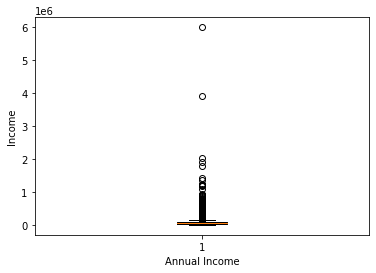

In [7]:
#Plotting boxplot for the annual income
plt.boxplot(fdf['annual_inc'])
plt.xlabel('Annual Income')
plt.ylabel('Income')
plt.show()

In [8]:
# As observed above there are too many outliers for Annual income. Hence cleaning is required. Hence we find IQR and filter the dataframe based 
# on upper fence and lower fence values
iqr=fdf['annual_inc'].quantile(0.75)-fdf['annual_inc'].quantile(0.25)
u_fence=fdf['annual_inc'].quantile(0.75)+(1.5*iqr)
l_fence=fdf['annual_inc'].quantile(0.25)-(1.5*iqr)
fdf=fdf[(fdf['annual_inc']>l_fence) & (fdf['annual_inc']<u_fence)]

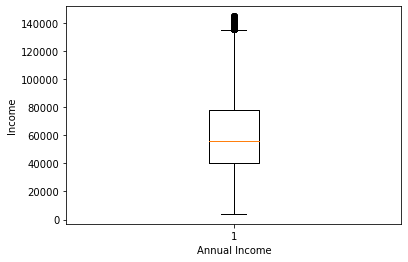

In [9]:
#Plotting boxplot again for the annual income after removing outliers
plt.boxplot(fdf['annual_inc'])
plt.xlabel('Annual Income')
plt.ylabel('Income')
plt.show()

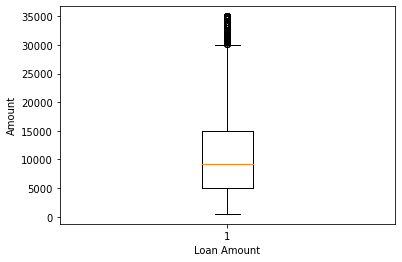

In [10]:
#Plotting boxplot for loan amount
plt.boxplot(fdf['loan_amnt'])
plt.xlabel('Loan Amount')
plt.ylabel('Amount')
plt.show()

In [11]:

# From above plot we observed that values above 30000 are outliers. We observe the count of loans above 30000 and we find
# the values are less. So we can remove the outliers
fdf[(fdf['loan_amnt']>30000)].shape[0]


547

In [12]:
# Removing outliers from Loan amount. 
fdf=fdf[(fdf['loan_amnt']<30000)]

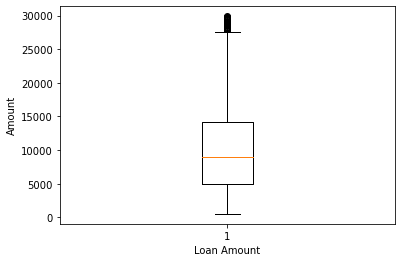

In [13]:
# Plotting boxplot for loan amount after removing outliers
plt.boxplot(fdf['loan_amnt'])
plt.xlabel('Loan Amount')
plt.ylabel('Amount')
plt.show()

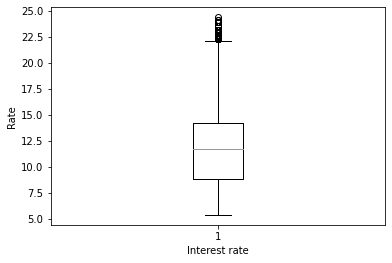

In [14]:
#Plotting boxplot for Interest rate
plt.boxplot(fdf['int_rate'])
plt.xlabel('Interest rate')
plt.ylabel('Rate')
plt.show()

In [15]:
# From above plot we observed that values above 22.5 are outliers. We observe the count of interest rates above 22.5 and we find
# the values are less. So we can remove the outliers
fdf[(fdf['int_rate']>22.5)].shape[0]

37

In [16]:
# Removing outliers from interest rate. 
fdf=fdf[(fdf['int_rate']<=22.5)]

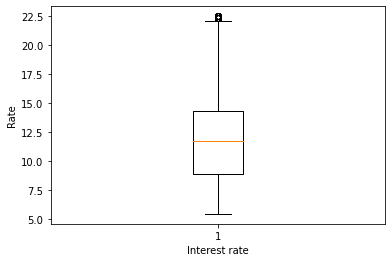

In [17]:
#Plotting boxplot for Interest rate
plt.boxplot(fdf['int_rate'])
plt.xlabel('Interest rate')
plt.ylabel('Rate')
plt.show()

### Additional null value treatement and data processing

Certain entiries have still null values remaining. We drop those entities altogether.<br>

In [18]:
#Finding null values in revol_util column and cleaning corresponding rows.
fdf['revol_util'].isna().sum(axis=0)
fdf.dropna(subset=['revol_util'],inplace=True)

It is observed that certain numerical variables are of object datatype. Such datatypes needs to be converted to relevant
datatypes for further analysis and plotting. This is done by identifying the textual part of the data and removing them.<br>

In [19]:
#Removing percentage (%) from revol_util and convert column to float type
fdf['revol_util']=fdf['revol_util'].apply(lambda x: float(x.strip('%')))

In [20]:
# Converting issue_d to pandas datetime object and extracting month and Year information for EDA
fdf['issue_d']=pd.to_datetime(fdf['issue_d'],format='%b-%y') 
fdf['loan_issue_month']=fdf['issue_d'].dt.month
fdf['loan_issue_year']=fdf['issue_d'].dt.year

# Creation of derived categorical values

Here we are splitting the Loan amount into segments for easier analysis.

In [21]:
#Split the annual income into groups for EDA
fdf['income_group']=pd.qcut(fdf['annual_inc'],q=[0,0.25,0.75,1],labels=['Low Income','Medium Income','High Income'])
min_quantile_value=fdf['annual_inc'].quantile(0.25)
max_quantile_value=fdf['annual_inc'].quantile(0.75)
maximum=fdf['annual_inc'].max()
low_Income=0-min_quantile_value
Medium_Income=min_quantile_value-max_quantile_value
High_Income=max_quantile_value-maximum

# Creation of business driven values

Here we are obtaining a new column for loan to income ratio (lar).This will be used for our analysis.

In [22]:
# Creating a new column for the ratio of loan and annual income
fdf['ratio']=fdf['loan_amnt']/fdf['annual_inc']

### Perform Sanity Checks

In this section we perform additional sanity checks to ensure that the data given to us is consistent with the definition of the data in the data dictionary.

In [23]:
fdf.head(5)

,id,member_id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,revol_util,total_acc,recoveries,last_pymnt_d,next_pymnt_d,pub_rec_bankruptcies,loan_issue_month,loan_issue_year,income_group,ratio
0,1077501,1296599,5000,36 months,10.65,162.87,B,B2,NaN,10+ years,...,83.7,9,0.00,Jan-15,NaN,0.0,12,2011,Low Income,0.208333
1,1077430,1314167,2500,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,9.4,4,117.08,Apr-13,NaN,0.0,12,2011,Low Income,0.083333
2,1077175,1313524,2400,36 months,15.96,84.33,C,C5,NaN,10+ years,...,98.5,10,0.00,Jun-14,NaN,0.0,12,2011,Low Income,0.195886
3,1076863,1277178,10000,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,21.0,37,0.00,Jan-15,NaN,0.0,12,2011,Medium Income,0.203252
5,1075269,1311441,5000,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,...,28.3,12,0.00,Jan-15,NaN,0.0,12,2011,Low Income,0.138889


In [24]:
#Loan issue month should be in range of 1-12
fdf[(fdf['loan_issue_month']<1) & (fdf['loan_issue_month']>12)].shape[0]

0

In [25]:
#Revoling utilization should not exceed 100%
fdf[(fdf['revol_bal']<0) & (fdf['revol_bal']>100)].shape[0]

0

In [26]:
#Checking with Employee sub grade lies within grade. In case the sum is non zero means there is mismatch
def sanity_check_grade(x):  
    if(x['grade'] in x['sub_grade']):
        return False
    else:
        return True
fdf.apply(sanity_check_grade, axis=1).sum()

0

# Data Analysis for various Driver Variables

### Driver Variables

Analysis is done on the below driver variables in order to find the impact of each variable on the loan status:<br><br>

Annual income<br>
Loan Amount<br>
Interest Rate<br>
Grade<br>
Sub grade<br>
Address state<br>
Zip code<br>
Purpose <br>
Employement Length<br>
Verification Status<br>
Issue Date<br>

Note: Loan amount funded and Loan amount funded by Investors is not considered as those can be highly volatile factors and depend on the market status, investment by investor. Hence Borrower requested loan amount is considered for analysis. 

# 1. Annual Income

### Univariate Analysis

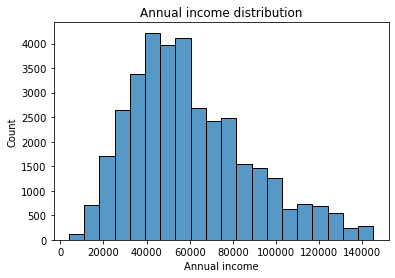

In [27]:
##univariate Analysis on Annual_inc:
sns.histplot(fdf['annual_inc'], bins=20)
plt.title('Annual income distribution')
plt.xlabel(xlabel='Annual income')
plt.show()
#conclusion:
     #here most of people having income 60000.

count     35857.000000
mean      60360.208132
std       27675.746636
min        4000.000000
25%       40000.000000
50%       55000.000000
75%       76000.000000
max      144997.000000
Name: annual_inc, dtype: float64


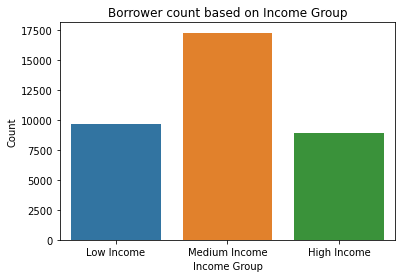

In [28]:
y=sns.countplot(x='income_group', data=fdf)
y.set_xlabel('Income Group')
y.set_ylabel('Count')
plt.title('Borrower count based on Income Group')
print(fdf.annual_inc.describe())
plt.show()

#### The key for the income group is as follows 

1. Low Income: Borrowers whose annual income is below `$`40000.
2. Medium Income: Borrowers whose annual income is between `$`40000 and `$`76300. 
3. High Income: Borrowers whose annual income is above `$`76300.  

### Conclusion drawn about Annual Income

1. The maximum count of loan is taken by borrowers whose annual income lies within range of `$`40000 - `$`60000.
2. Very few borrowers whose annual income is upwards of `$`80000 take loan.
3. Most of the borrowers taking loan fall in the Medium Income group category.

### Bivariate/Mutlivariate Analysis

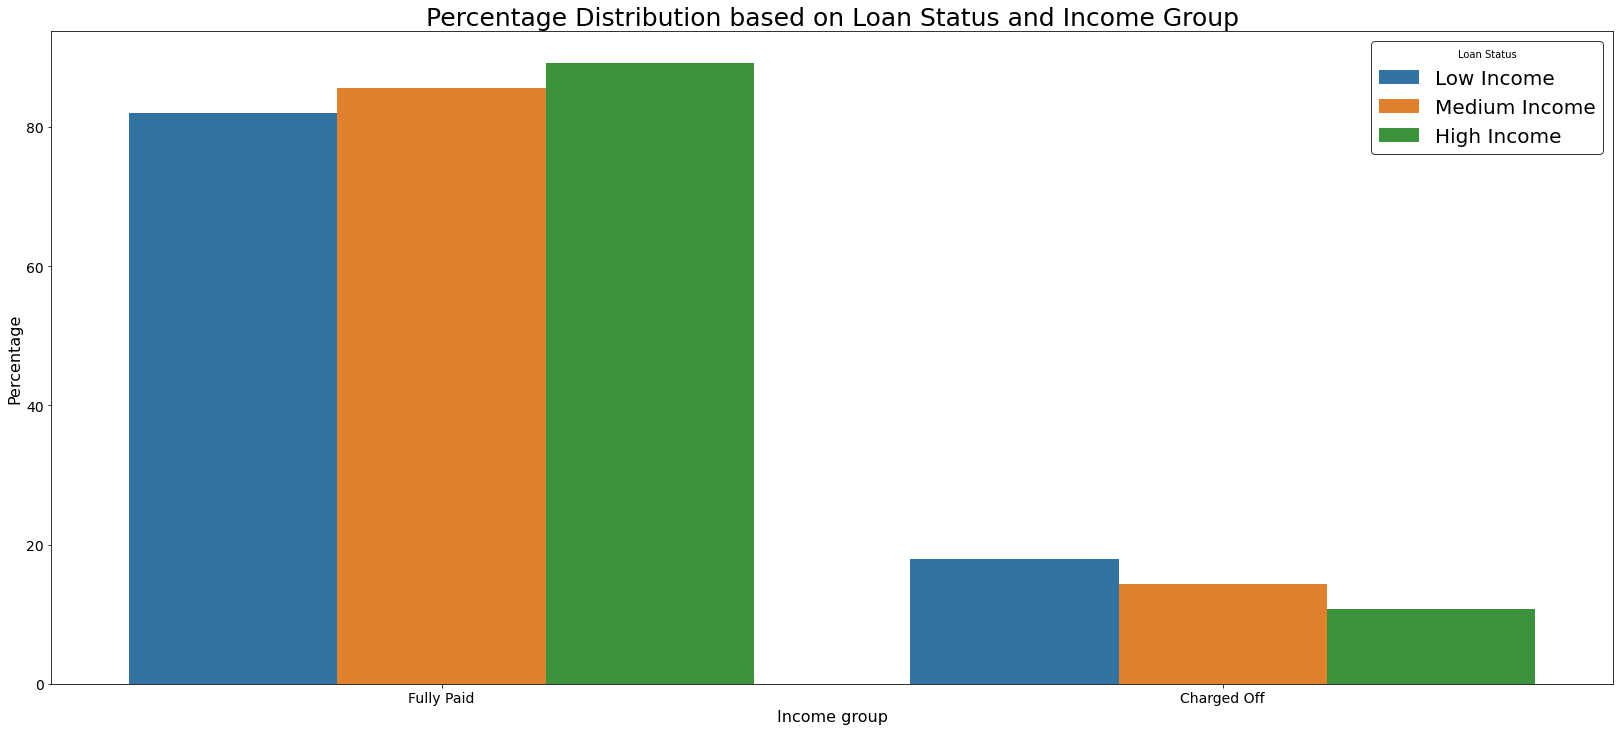

In [29]:
##Bivariate analysis on Annual_inc
#Annual_inc on based on loan_status and grade:
fig, ax = plt.subplots(nrows=1, figsize=(28,12))
df1=fdf.groupby('income_group')['loan_status'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g = sns.barplot(x='loan_status',y='percentage', hue='income_group', data=df1)
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Income group',fontsize=16)
g.set_ylabel('Percentage',fontsize=16)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={"size":20})
g.set_title('Percentage Distribution based on Loan Status and Income Group',fontsize=25)
#conclusion:
    #Here people who are having low income are more no of defaulters
#Annual_inc based on loan_amount :
plt.show()

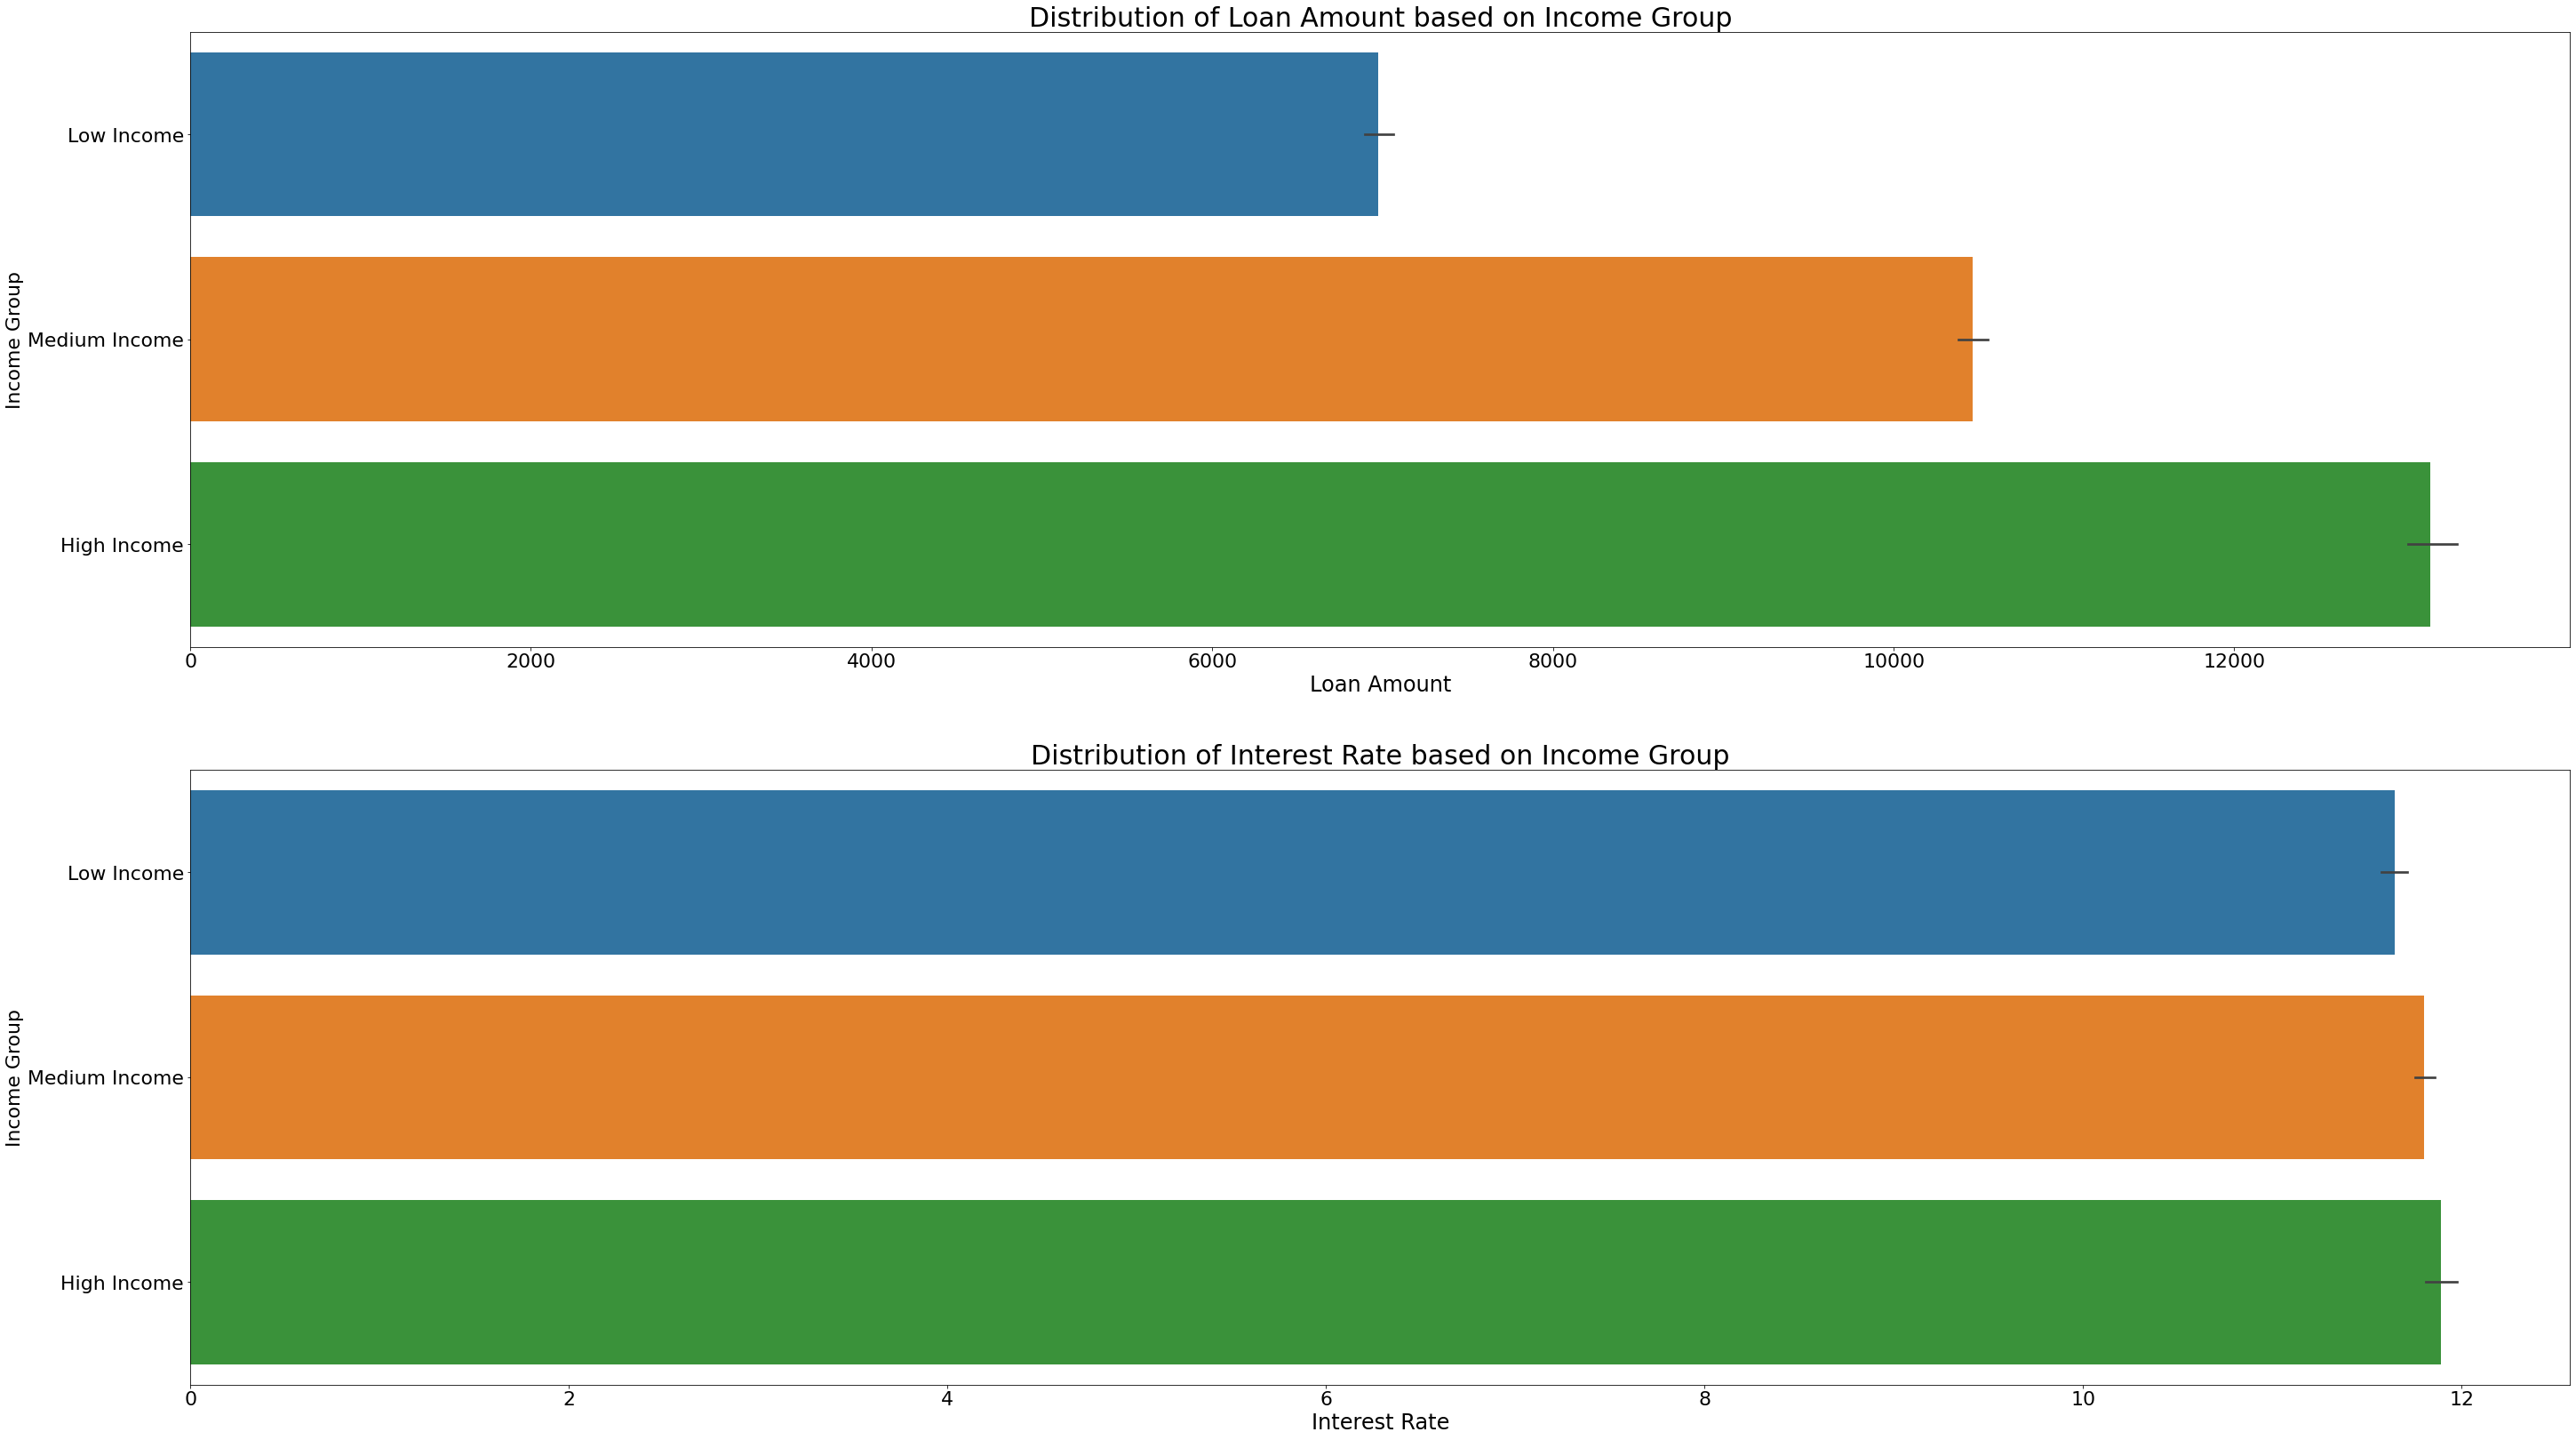

In [30]:
fig, ax = plt.subplots(nrows=2,figsize=(48,28))
i = sns.barplot(x='loan_amnt', y='income_group', data=fdf, ax=ax[0])
i.set_xlabel('Loan Amount',fontsize=24)
i.tick_params(axis='both', labelsize=22)
i.set_ylabel('Income Group',fontsize=22)
i.set_title('Distribution of Loan Amount based on Income Group', fontsize=30)
#conclusion:
      #Borrowers belonging to higher income category generally take more amount of loan
#Annual_inc based on intrest_rate:
k = sns.barplot(x='int_rate', y='income_group', data=fdf, ax=ax[1])
k.set_title('Barplot on interest rate based on income group', fontsize=14)
k.set_title('Distribution of Interest Rate based on Income Group', fontsize=30)
k.set_xlabel('Interest Rate',fontsize=24)
k.tick_params(axis='both', labelsize=22)
k.set_ylabel('Income Group',fontsize=22)
plt.show()

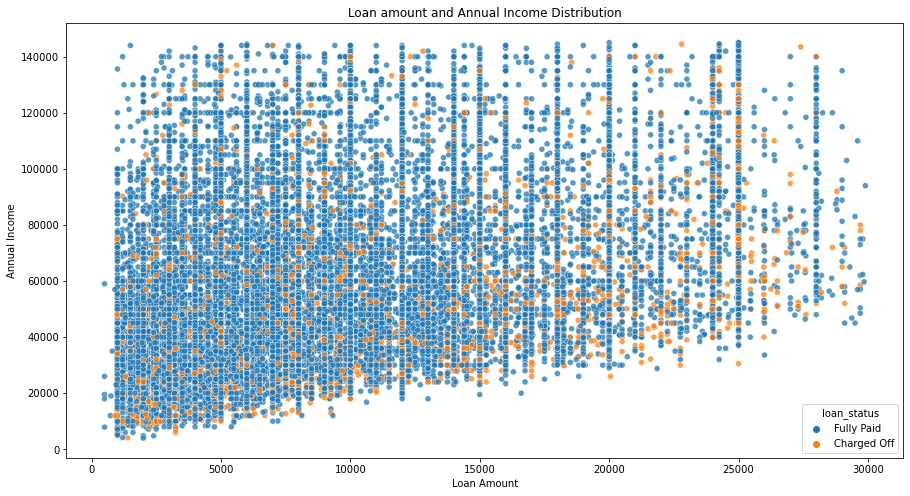

In [31]:
#Trivariate analysis
plt.figure(figsize = (15,8))
g=sns.scatterplot(x='loan_amnt',y='annual_inc',data=fdf,alpha=0.75,hue='loan_status')
g.set_xlabel('Loan Amount')
g.set_ylabel('Annual Income')
g.set_title('Loan amount and Annual Income Distribution')
#plt.legend(labels=['fully paid','charged off'])
plt.show()
#conclusion:
   #Here people having annual income of 80000 and loan amount of 10000 are more taking loan so if interest will be higher
       #company will gain profit and if above these values if company gives loan with less interest rate , it can attract more borrowers.

### Additioanal Conclusion drawn about Annual Income 

1. Borrowers who belong to low income category have higher chance of defaulting the loan.
2. The amount of loan taken by a borrower increases with the increase in annual income. 
3. The lender is charging uniform interest rates irrespective of the income group to which the borrower belongs.
4. The chances of a borrower defaulting the loan is higher if his annual income is lower.
5. More number of borrowers who have high chance of defaulting take loan less than `$`15000.

# Loan amount

### Univariate Analysis

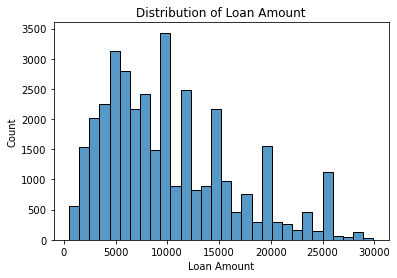

In [32]:
#Description:
    #The amount which taken by borrower from bank for fixed period of time and interest.
#univariate analysis:
g=sns.histplot(x='loan_amnt', bins=30, data=fdf)
plt.title('Distribution of Loan Amount')
g.set_xlabel('Loan Amount')

plt.show()
#conclusion:
     #Majority of people are taking loan below 10000

In [33]:
print(fdf.loan_amnt.describe())

count    35857.000000
mean     10193.014614
std       6269.339620
min        500.000000
25%       5000.000000
50%       9000.000000
75%      14125.000000
max      29900.000000
Name: loan_amnt, dtype: float64


### Conclusion drawn about Loan Amount

1. Majority of borrowers take loan amount less than `$`10000.

### Bivariate/Mutlivariate Analysis

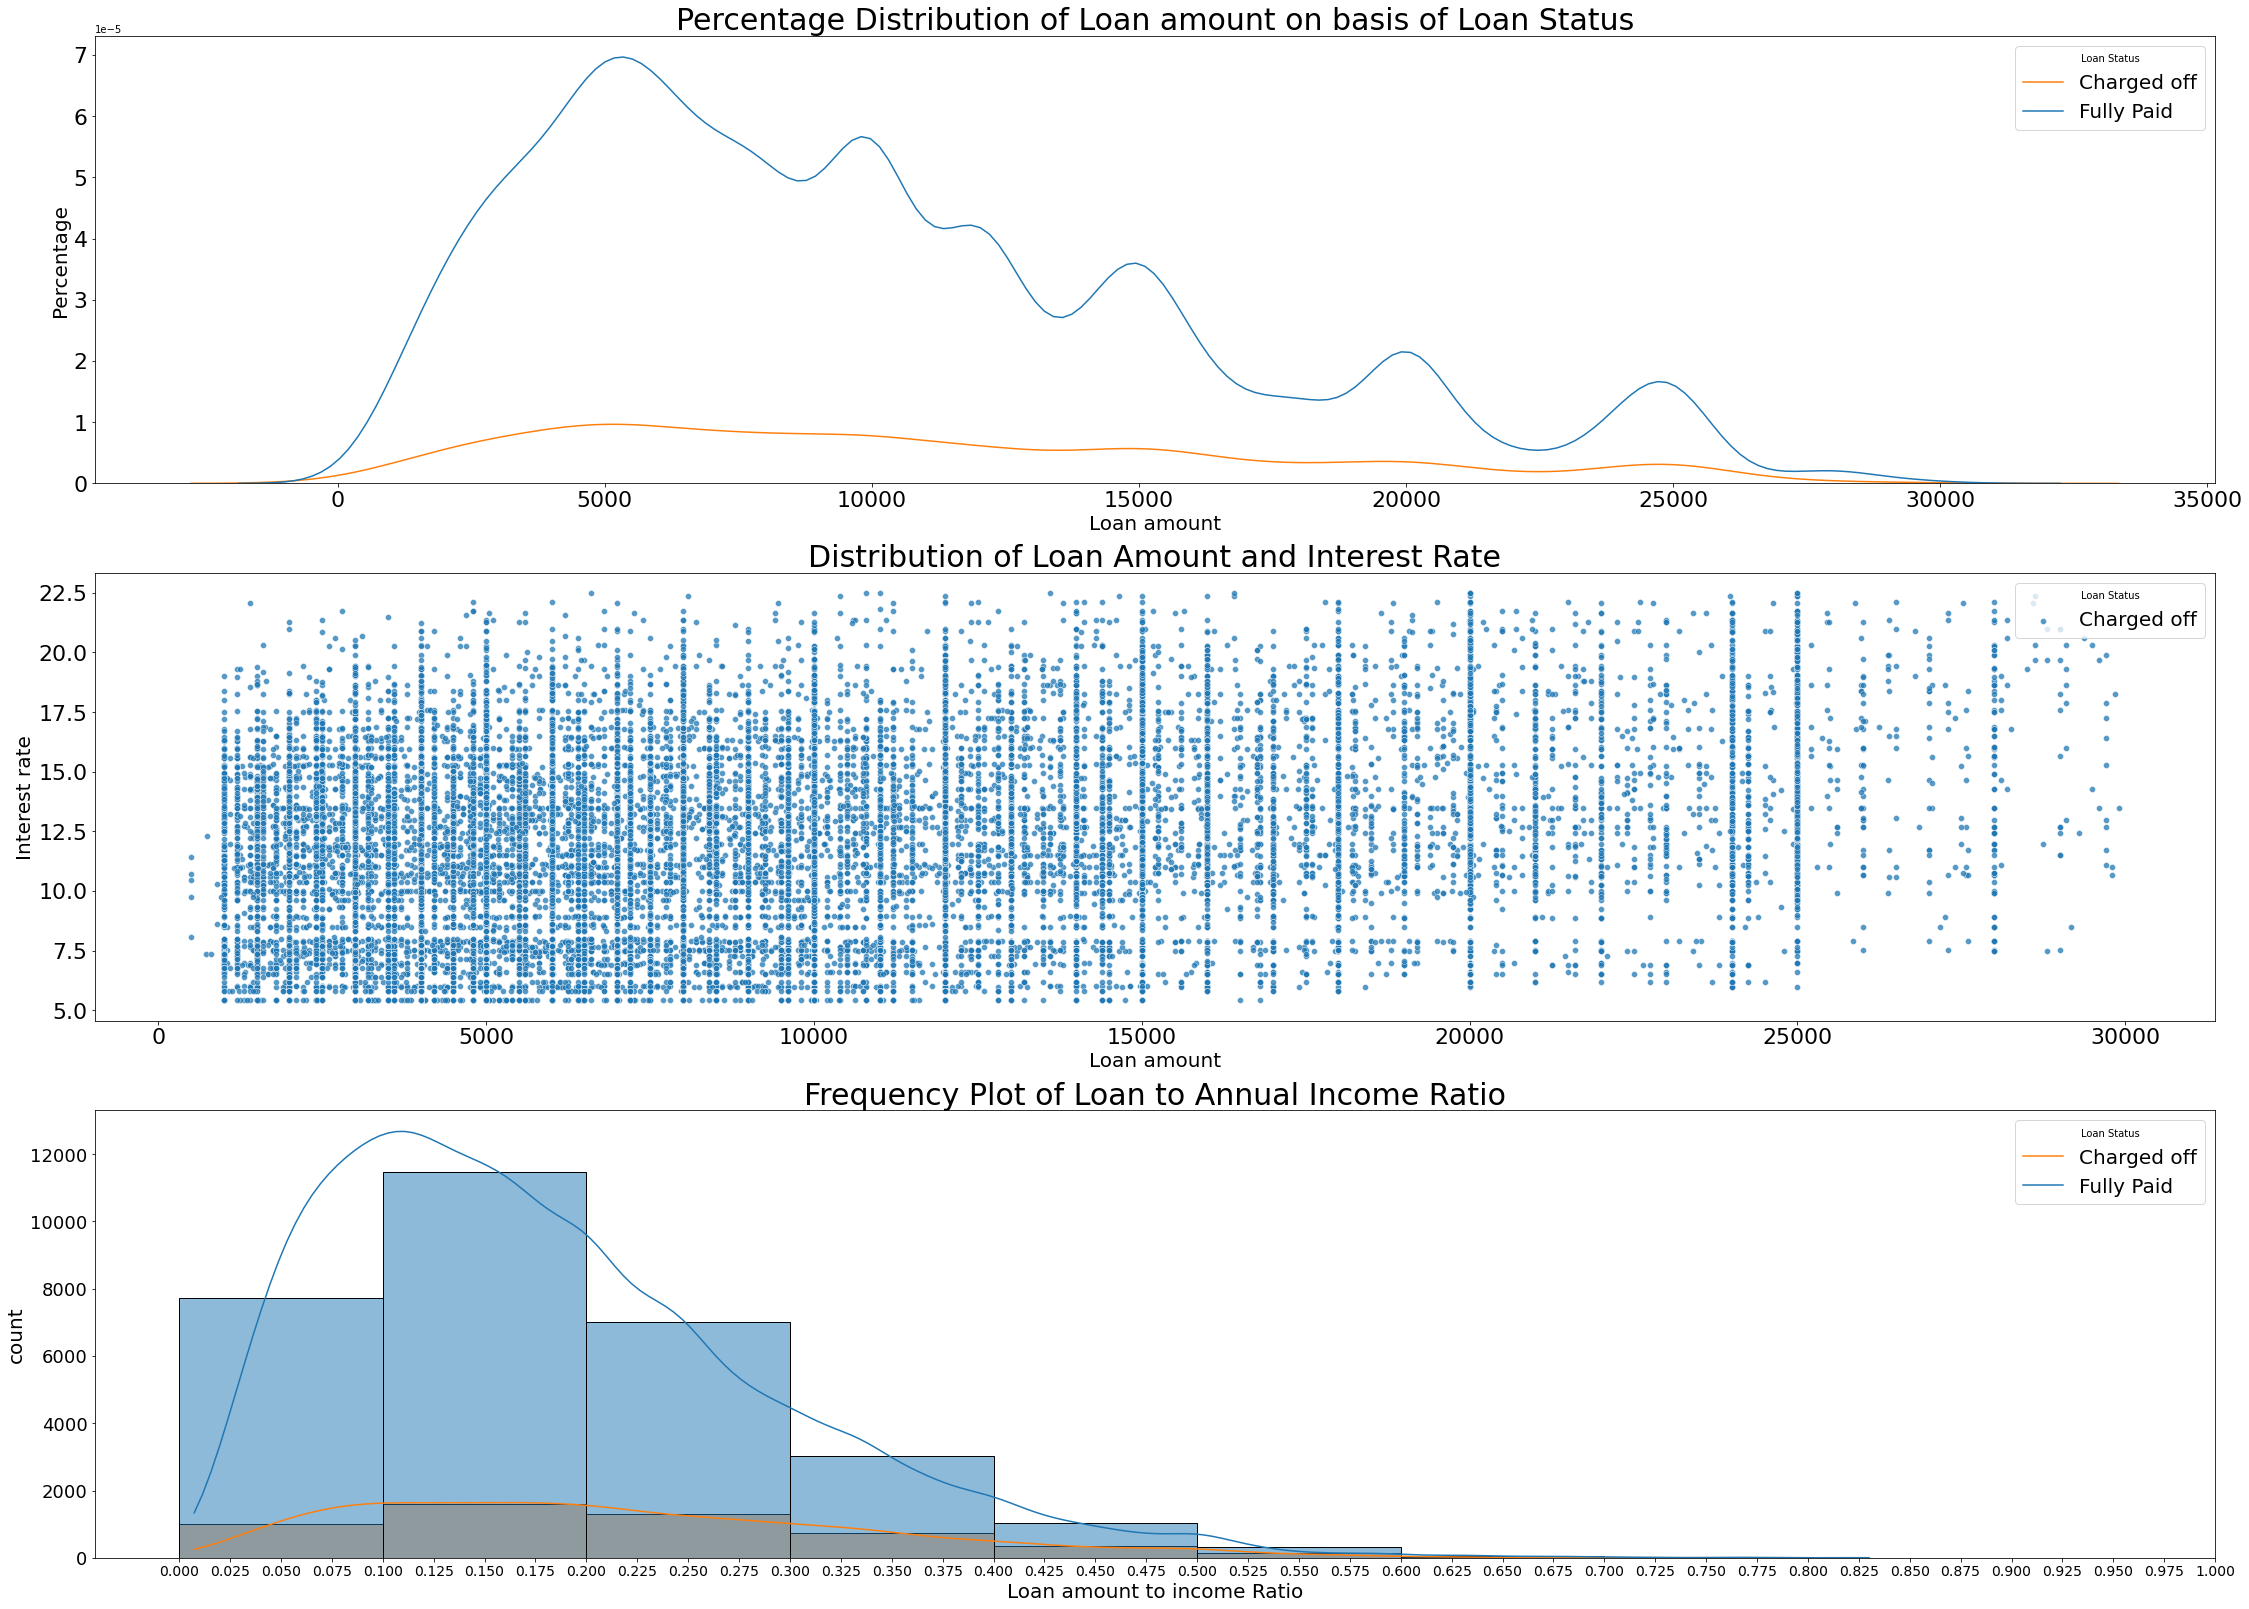

In [34]:
#Bivariate analysis:
#Loan amount with loan status:
figure, ax = plt.subplots(nrows=3, figsize=(38,28))
g = sns.kdeplot(x='loan_amnt', hue='loan_status',data=fdf,ax=ax[0])
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Loan amount',fontsize=20)
g.set_ylabel('Percentage',fontsize=20)
g.tick_params(axis='both', labelsize=22)
g.legend(title='Loan Status',labels=['Charged off','Fully Paid'],loc=1,prop={"size":20})
g.set_title('Percentage Distribution of Loan amount on basis of Loan Status',fontsize=30)
#conclusion:
    #Here people taking loan around 5000 have more chance of defaulting 
g=sns.scatterplot(x='loan_amnt',y='int_rate',data=fdf,alpha=0.75,ax=ax[1])
g.set_title('Reln betn loan amount and interest rate')
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Loan amount',fontsize=20)
g.set_ylabel('Interest rate',fontsize=20)
g.tick_params(axis='both', labelsize=22)
g.legend(title='Loan Status',labels=['Charged off','Fully Paid'],loc=1,prop={"size":20})
g.set_title('Distribution of Loan Amount and Interest Rate',fontsize=30)
#conclusion:
    #Here most of people are taking loan of 5000 and interst rate of 12.5. 
fdf['ratio']=fdf['loan_amnt']/fdf['annual_inc']
decades=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
g=sns.histplot(x='ratio',hue='loan_status',bins=decades,kde=True,data=fdf,ax=ax[2])
g.set_title('Distribution plot on Ratio of loan_amnt and annual_inc')
plt.xticks([x for x in np.arange(0,1.025,0.025)])

g.set_xlabel('Loan amount to income Ratio',fontsize=20)
g.tick_params(axis='both', labelsize=14)
g.set_ylabel('count',fontsize=20)
g.tick_params(axis='y', labelsize=18)
g.set_title('Frequency Plot of Loan to Annual Income Ratio',fontsize=30)
g.legend(title='Loan Status',labels=['Charged off','Fully Paid'],loc=1,prop={"size":20})
#conclusion:
   ## None of borrowers took loan amount greater than annual income.
   # Most number of defaulters have loan to income ratio between 0.075 and 0.2.
plt.show()

### Additioanal Conclusion drawn about Loan Amount

1. Most of the borrowers who have high chance of defaulting take loan amount between `$`5000 and `$`10000.
2. Loan to Income ratio (lti) for borrowers who have high chance of defaulting lies between 0.075 to 0.2.
3. For none of the borrowers lti ratio is greater or equal to 1. It means the firm is not giving loan for very large capital investments.

# Interest Rate

### Univariate Analysis

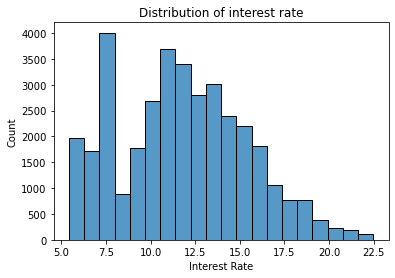

In [35]:
#Description:
     #Interest rate is the amount of interest due per period,as a propoition of the loan_amnt.
#univariate analysis:
sns.histplot(x='int_rate', bins=20, data=fdf)
plt.title('Distribution of interest rate')
plt.xlabel('Interest Rate')
plt.show()
#conclusion:
   #Sharp dip is observed for borrowers taking loan around 8% interest. Reason.

In [36]:
fdf.int_rate.describe()

count    35857.000000
mean        11.782765
std          3.592896
min          5.420000
25%          8.900000
50%         11.710000
75%         14.260000
max         22.480000
Name: int_rate, dtype: float64

In [37]:
fdf.groupby('loan_status')['int_rate'].describe()
#conclusion:
   #Charged Off peoples have more interest comparing to fully paid.

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5181.0,13.581455,3.529439,5.42,11.12,13.49,16.02,22.48
Fully Paid,30676.0,11.478976,3.513818,5.42,8.49,11.36,13.85,22.48


### Conclusion drawn about Interest Rate

1. One interesting thing is observed that lender is giving most loans at 7.5% interest rate and after that there is sudden dip. One of the the reason may be that beyond 7.5% interest rate additional taxes are levived.
2. Borrowers who have more chance of defaulting tend to have taken loan with higher interest rates.
3. For most of the borrowers the interest rate charged is below 12%.

### Bivariate/Mutlivariate Analysis

<ipython-input-38-38bd0866e346>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels([x for x in np.arange(5,30,1.5)])


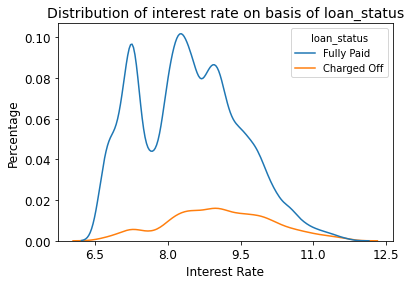

In [38]:
### Bivariate analysis:
g=sns.kdeplot(x='int_rate', hue='loan_status', data=fdf)
g.tick_params(axis='both',labelsize=12)
g.set_xlabel('Interest Rate',fontsize=12)
g.set_ylabel('Percentage',fontsize=12)
g.set_xticklabels([x for x in np.arange(5,30,1.5)])
g.set_title('Distribution of interest rate on basis of loan_status',fontsize=14)
#conclusion:
   #here people who are defaulters having interest mostly 10.0-15.5.
plt.show()

### Additional Conclusion drawn about Interest Rate

1. For most borrowers who is charged interest rate between 8% to 9.5% have high chance of defaulting.

# Grade

### Univariate Analysis

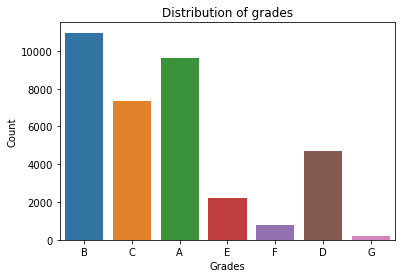

In [39]:
#Description:
     #It is classification system that involves assigning a quality score to a loan based on a borrower's credit.
#univariate
g=sns.countplot(x='grade', data=fdf)
plt.title('Distribution of grades')

plt.xlabel('Grades')
plt.ylabel('Count')
plt.show()
#conclusion:
     #people of B grade are more.

### Conclusion drawn about Grade

1. Majority of the borrowers belong to Grade B as per the provided data.
2. After Grade B, the 3 other most popular grades are A,C and D.
3. A very less number of people belong to grade G.

### Bivariate/Mutlivariate Analysis

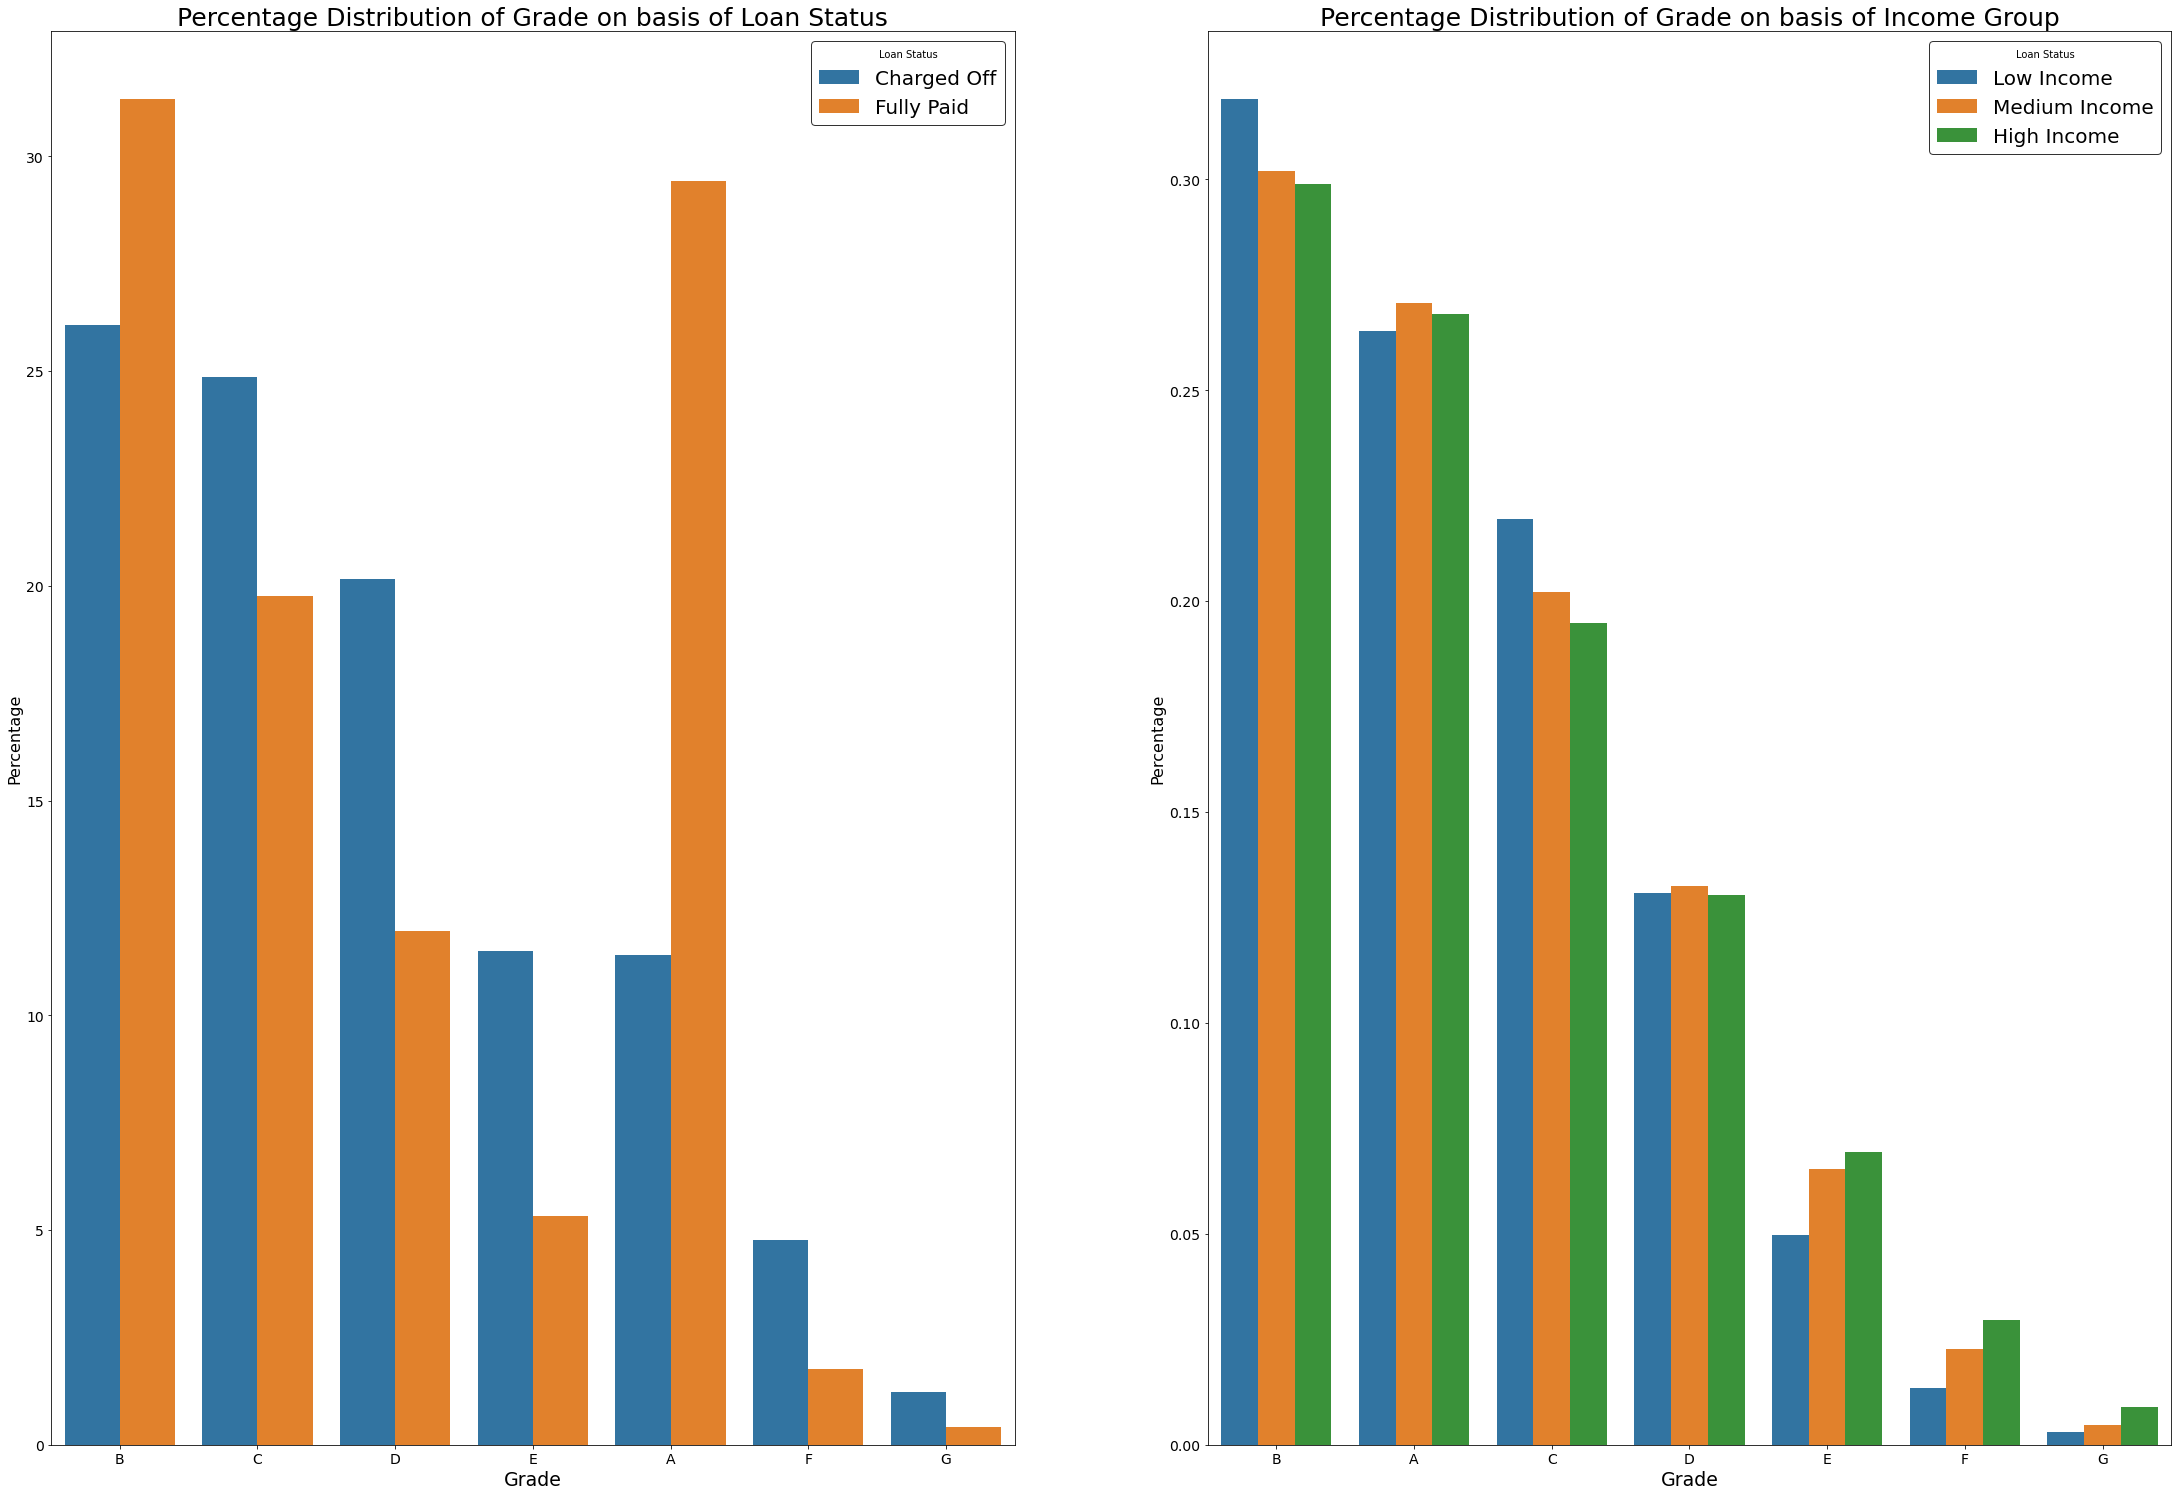

In [71]:
#Bivariate analysis
#Grade on basis of loan status:
figure, ax = plt.subplots(nrows=1 ,ncols=2,figsize=(38,26))
df1=fdf.groupby('loan_status')['grade'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='grade',y='percentage',hue='loan_status',data=df1,ax=ax[0])
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Grade',fontsize=19)
g.set_ylabel('Percentage',fontsize=16)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={"size":20})
g.set_title('Percentage Distribution of Grade on basis of Loan Status',fontsize=25)
df2=fdf.groupby('income_group')['grade'].value_counts(normalize=True).rename('percentage').reset_index()
g=sns.barplot(x='grade',y='percentage',hue='income_group',data=df2)
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Grade',fontsize=19)
g.set_ylabel('Percentage',fontsize=16)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={"size":20})
g.set_title('Percentage Distribution of Grade on basis of Income Group',fontsize=25)
#conclusion:
    #In general if a person is belonging to grade C and he is in low income group he will have more chance of defaulting
    # People belonging to grade C , D and E have more chance of defaulting.
plt.show()

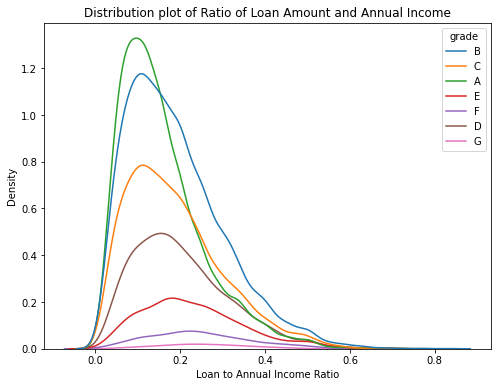

In [41]:
figure, ax = plt.subplots(nrows=1,figsize=(8,6))
g=sns.kdeplot(x='ratio',hue='grade',data=fdf)
g.set_title('Distribution plot of Ratio of Loan Amount and Annual Income')
plt.xlabel('Loan to Annual Income Ratio')
plt.show()
#conclusion:
     #The loan to income ratio for defaulters still lie within 0.075 to 0.2 for grades C,D and E

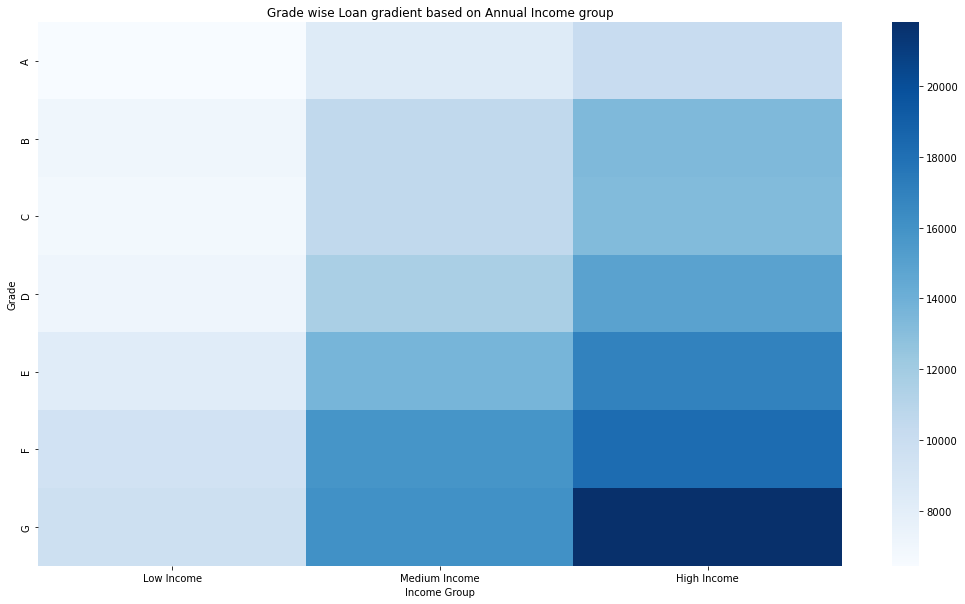

In [42]:
#TRivariate analysis:
figure, ax = plt.subplots(nrows=1,figsize=(18,10))
k=sns.heatmap(fdf.pivot_table(index='grade',columns='income_group',values='loan_amnt',aggfunc=np.mean),cmap='Blues')
k.set_title('Grade wise Loan gradient based on Annual Income group')
plt.ylabel('Grade')
plt.xlabel('Income Group')
#conclusion:
    #here we can clearly see people who are in grade C,D,E have more chance of defaulting and the chance of defaulting increases with increase in loan amount
plt.show()

### Additional Conclusion drawn about Grade

1. Borrowers belonging to Grade C,D,E,F and G have higher chance of defaulting the loan irrespective of their income category.
2. Grade A and B people are less likely to default the loan.
3. Borrower belonging to grade C and lower income category will have higher chance of defaulting than compared to other grades.
4. Borrower belonging to Grade C,D and E and having loan to income ratio between 0.075 and 0.2 will have higher chance of defaulting.
5. Borrowers belonging to higer grade taken bigger amount of loans compared to lower grade borrowers and their chance of defaulting is also less. This is due to the fact that they have higher annual income.

# subgrade

### Univariate Analysis

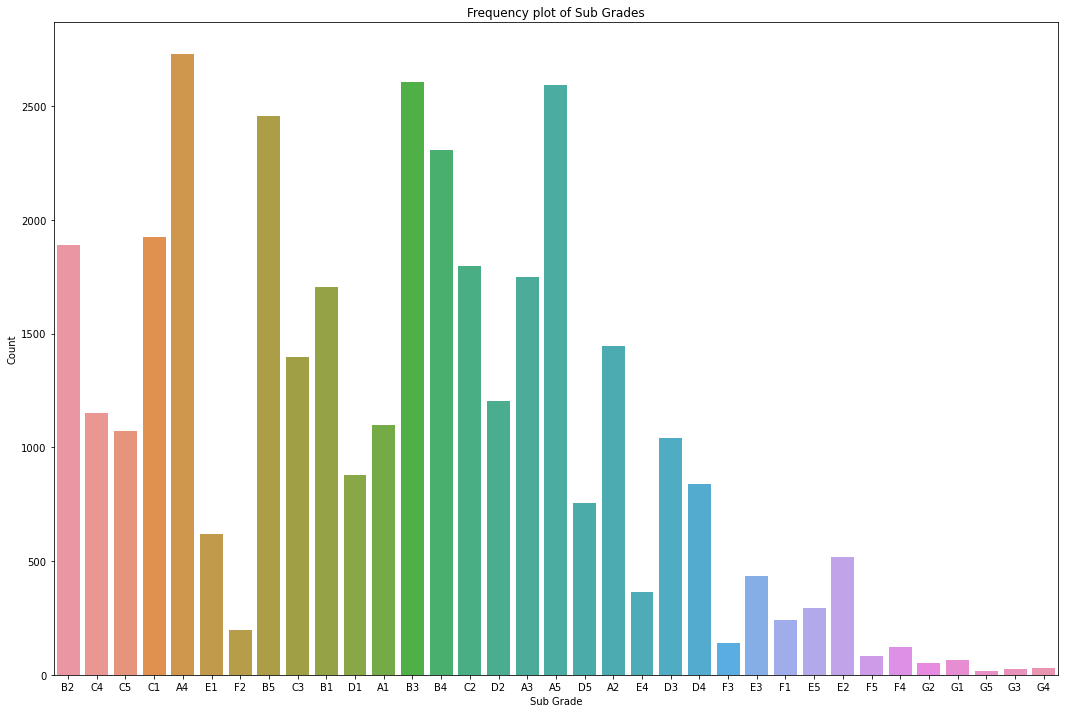

In [43]:
#Description:
      #According to the grade subgrade is assigned for borrowers.
#unvariate Analysis:
figure, ax = plt.subplots(nrows=1, figsize=(18,12))
sns.countplot(x='sub_grade',data=fdf)
plt.title('Frequency plot of Sub Grades')
plt.xlabel('Sub Grade')
plt.ylabel('Count')
plt.show()
#conclusion:
   #Here people in A4 are more.

### Bivariate/Mutlivariate Analysis

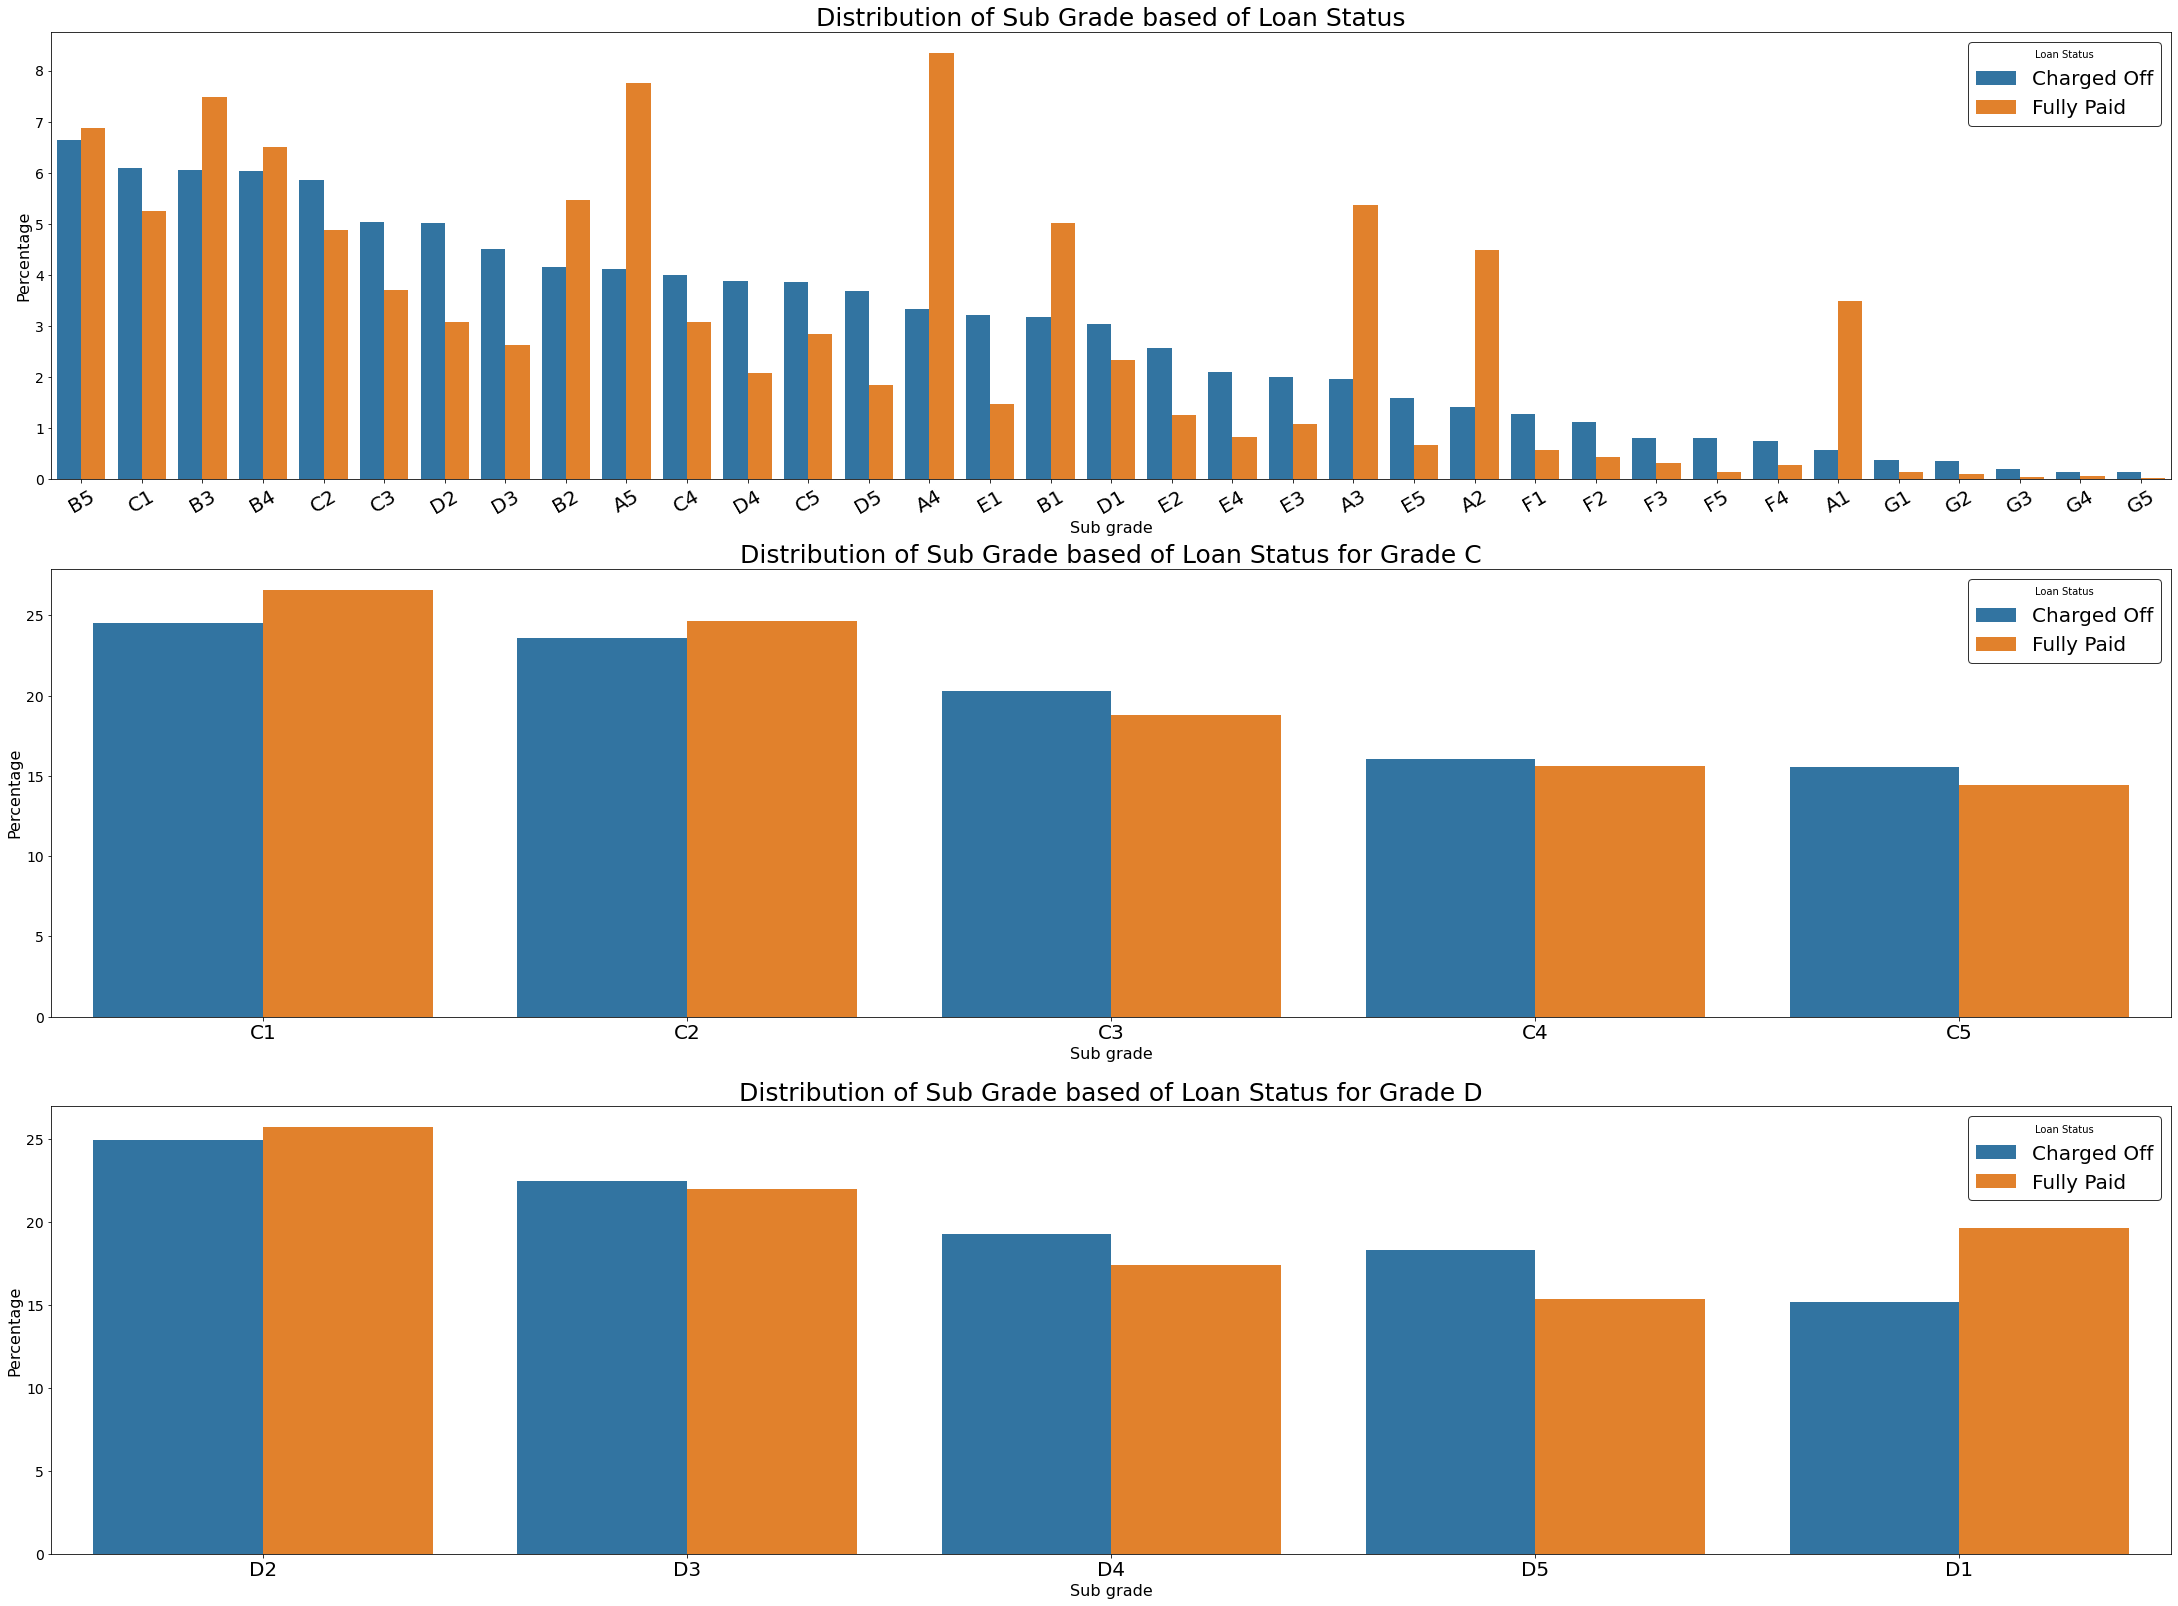

In [44]:
#Bivariate analysis:
figure, ax = plt.subplots(nrows=3, figsize=(38,28))
df1=fdf.groupby('loan_status')['sub_grade'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='sub_grade',y='percentage',hue='loan_status',data=df1,ax=ax[0])
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Sub grade',fontsize=16)
g.set_xticklabels(g.get_xticklabels(),rotation=30,fontsize=20)
g.set_ylabel('Percentage',fontsize=16)
g.set_title('Distribution of Sub Grade based of Loan Status',fontsize=25)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={"size":20})
df1=fdf[fdf['grade']=='C']
df2=df1.groupby('loan_status')['sub_grade'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='sub_grade',y='percentage',hue='loan_status',data=df2,ax=ax[1])
g.set_title('Barplot on subgrade basis of loan status')
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Sub grade',fontsize=16)
g.set_xticklabels(g.get_xticklabels(),fontsize=20)
g.set_ylabel('Percentage',fontsize=16)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={"size":20})
g.set_title('Distribution of Sub Grade based of Loan Status for Grade C',fontsize=25)
#conclusion:
   #here most of defaulters are from c3 and c4 and  fully paid are decreasing.
df3=fdf[fdf['grade']=='D']
df4=df3.groupby('loan_status')['sub_grade'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='sub_grade',y='percentage',hue='loan_status',data=df4,ax=ax[2])
g.set_title('Barplot on subgrade basis of loan status')
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Sub grade',fontsize=16)
g.set_ylabel('Percentage',fontsize=16)
g.set_xticklabels(g.get_xticklabels(),fontsize=20)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={"size":20})
g.set_title('Distribution of Sub Grade based of Loan Status for Grade D',fontsize=25)
#conclusion:
   #here According to sub_grades the defaulters are more.
plt.show()
#conclusion:
# The borrower belonging to any of the sub grade of grade D and E will have high chance of defaulting
# As the subgrade with  grade C and D increases the chance of defaulting also increases.
#Here the defaulters are more in b3, b5, b4

### Conclusion drawn about Sub-Grade

1. For Grade C and D it can be observed that the chance of defaulting increase with increase in sub-grade

# Home Ownership

### Univariate Analysis

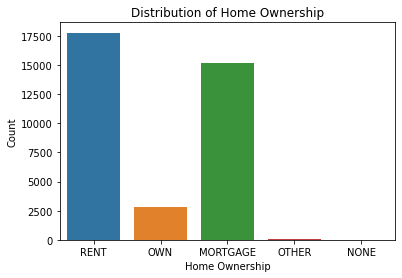

In [45]:
#Description:
   #House type of those people who are taking loan:
#univariate:
sns.countplot(x='home_ownership',data=fdf)
plt.title('Distribution of Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()
#conclusion:
    #Here people who are taking loan most are from rent, means their not basically from that area, where the bank is situated.

### Conclusion drawn about Property ownership

1. Maximum number of people taking loan are staying in Rented property.
2. Apart from Rent, many borrowers are staying in mortgage property or having their own property.

### Bivariate/Mutlivariate Analysis

<ipython-input-73-ffff5ce26a6f>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels([x for x in np.arange(0,1.025,0.015)],rotation=30,fontsize=20)


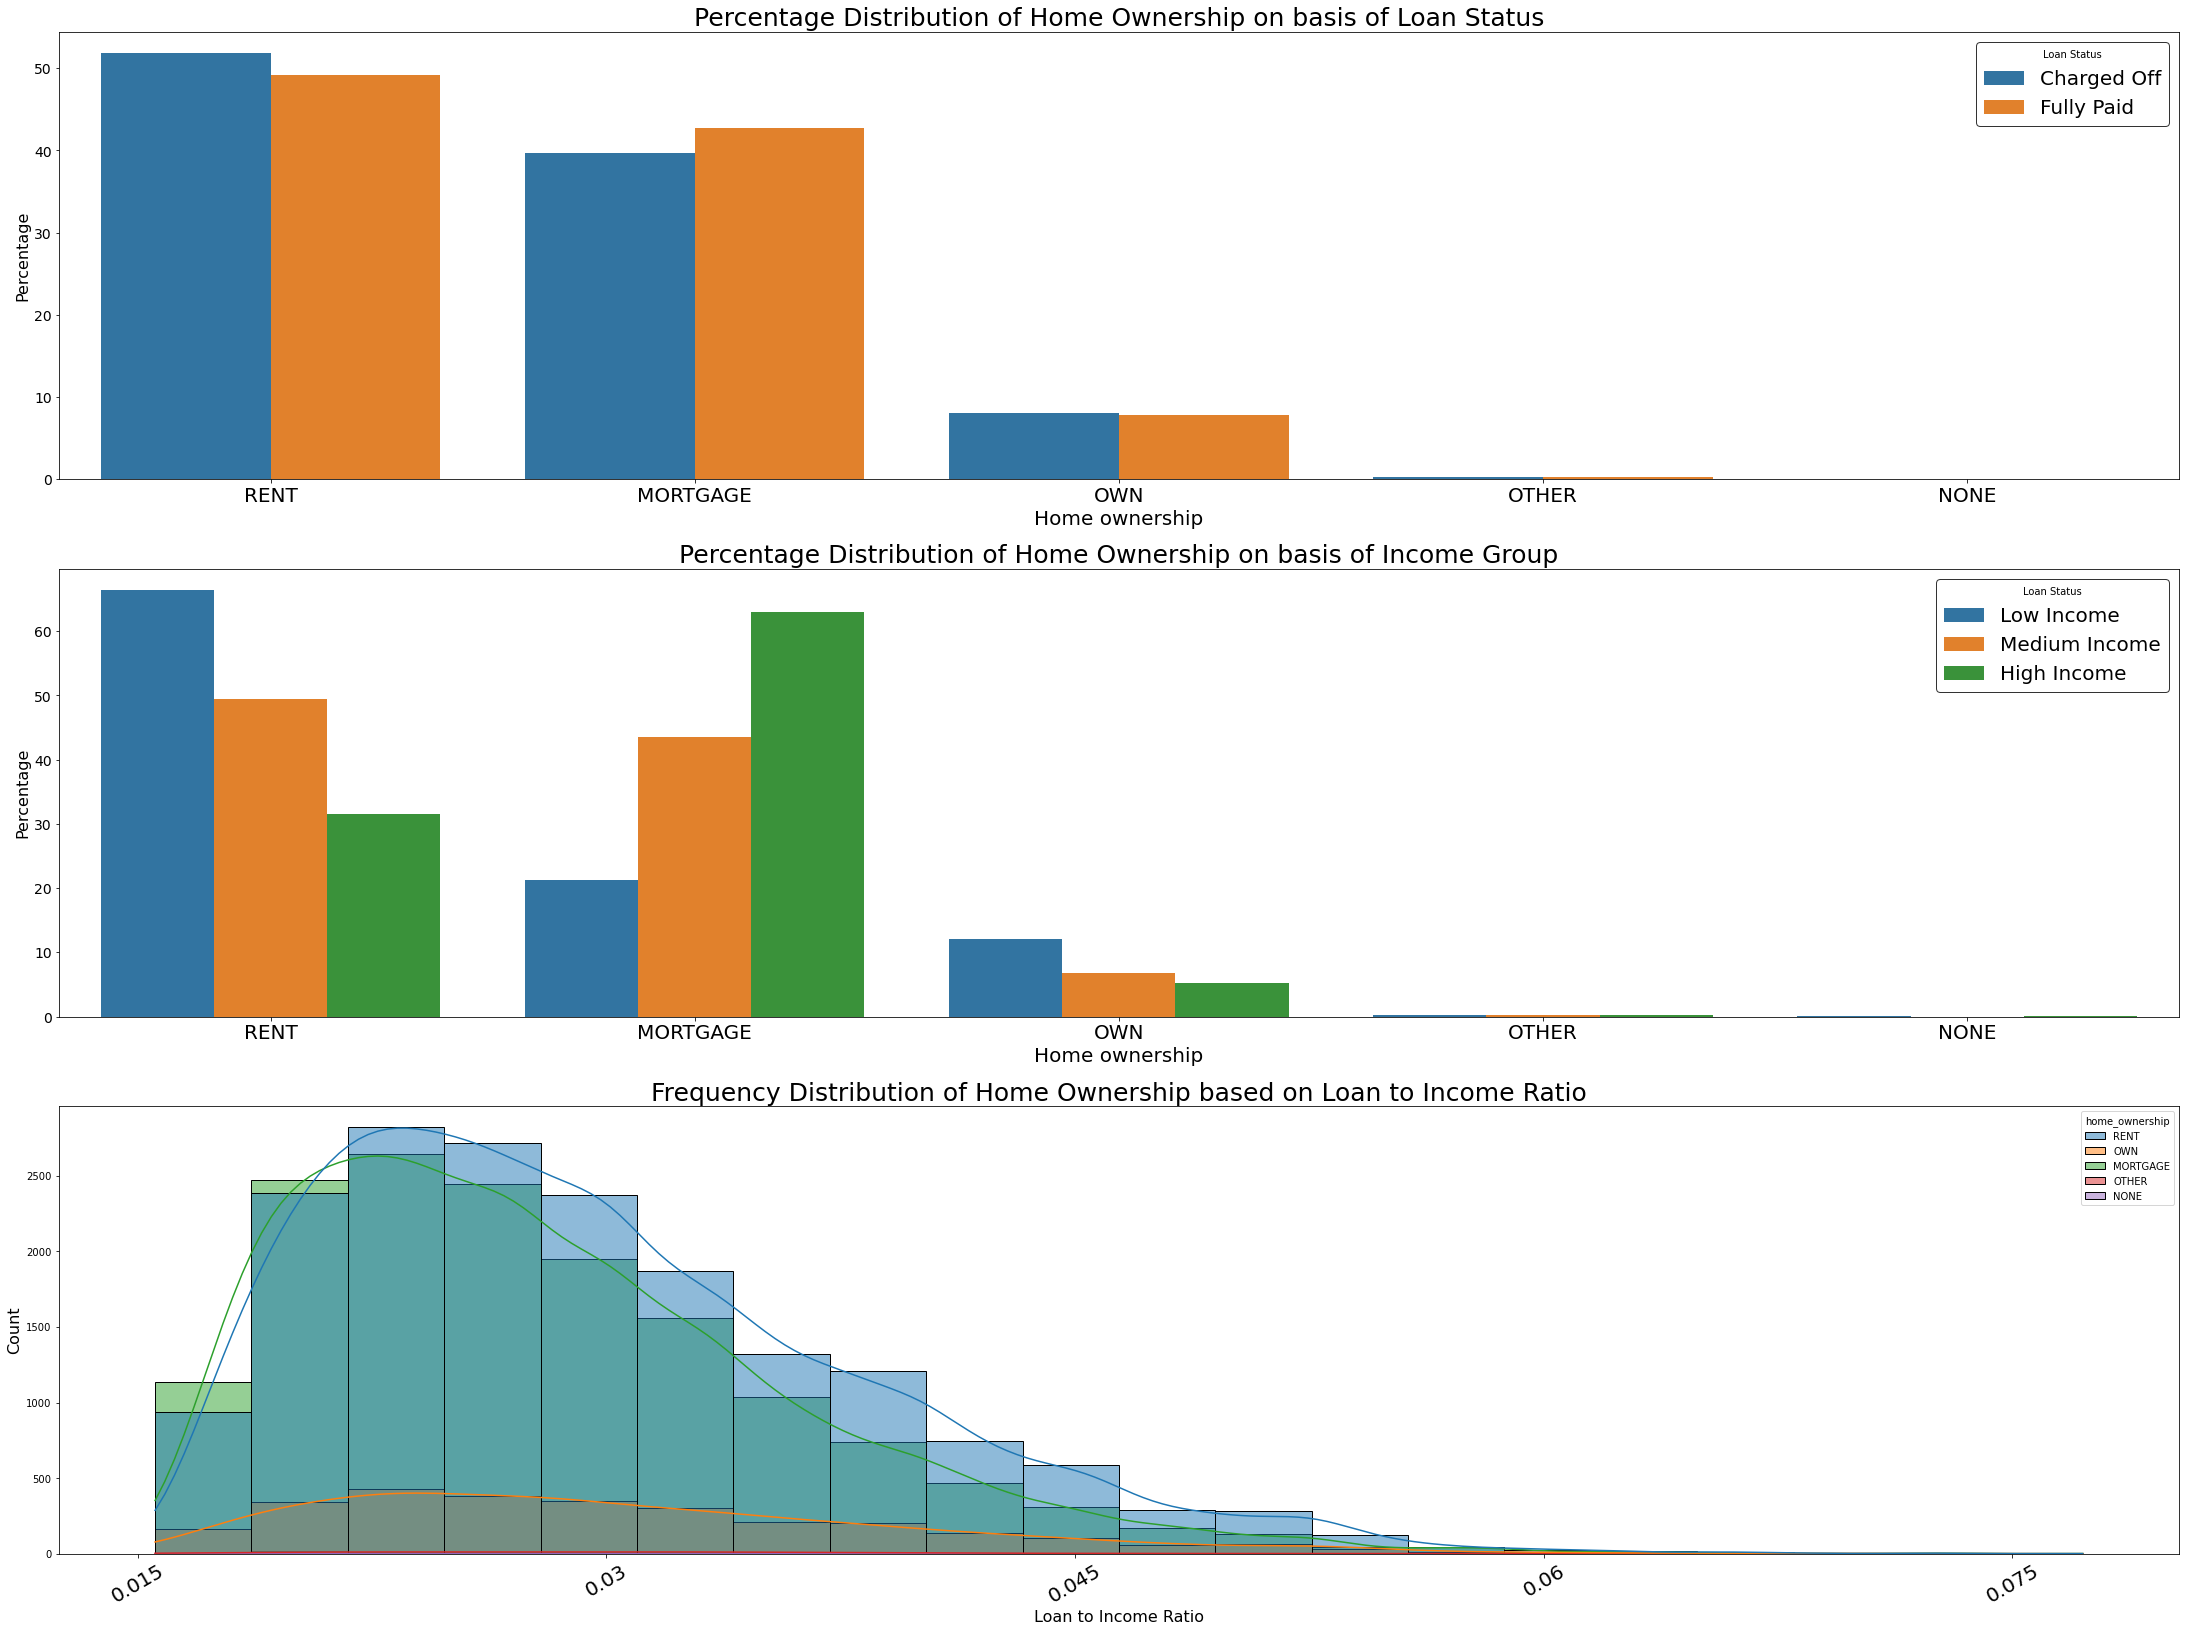

In [73]:
#Bivariate analysis:
figure, ax=plt.subplots(nrows=3,figsize=(38,28))
df1=fdf.groupby('loan_status')['home_ownership'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='home_ownership',y='percentage',hue='loan_status',data=df1,ax=ax[0])
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Home ownership',fontsize=20)
g.set_ylabel('Percentage',fontsize=16)
g.set_xticklabels(g.get_xticklabels(),fontsize=20)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={'size':20})
g.set_title('Percentage Distribution of Home Ownership on basis of Loan Status',fontsize=25)
#conclusion:
   #Here people who are Rent are mostly deafulters.
df3=fdf.groupby('income_group')['home_ownership'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='home_ownership',y='percentage',hue='income_group',data=df3,ax=ax[1])
g.set_title('Barplot on home ownership on basis of income_group')
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Home ownership',fontsize=20)
g.set_xticklabels(g.get_xticklabels(),fontsize=20)
g.set_ylabel('Percentage',fontsize=16)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={'size':20})
g.set_title('Percentage Distribution of Home Ownership on basis of Income Group',fontsize=25)
#conclusion:
   #Here most of defaulters are from rent are having low income.
g=sns.histplot(x='ratio',hue='home_ownership',bins=20,kde=True,data=fdf,ax=ax[2])
g.set_title('Distribution plot on Ratio of loan_amnt and annual_inc ')
g.set_xticklabels([x for x in np.arange(0,1.025,0.015)],rotation=30,fontsize=20)
g.set_xlabel('Loan to Income Ratio',fontsize=16)
g.set_ylabel('Count',fontsize=16)
g.set_title('Frequency Distribution of Home Ownership based on Loan to Income Ratio',fontsize=25)
plt.show()

### Additional Conclusion drawn about Property ownership

1. Borrowers living in Rented or mortgage property have greater chance of defaulting compared to borrowers having their own property.
2. Borrowers belonging to High Income Category and living in mortraged property might signify they have taken loans from other sources and can have more chance of defaulting.
3. Borrower belonging to low income category generally dont live in mortgage property.
4. Borrower belonging to low income category and staying in rented property have more chance of defaulting.

# Addrress state

### Univariate Analysis

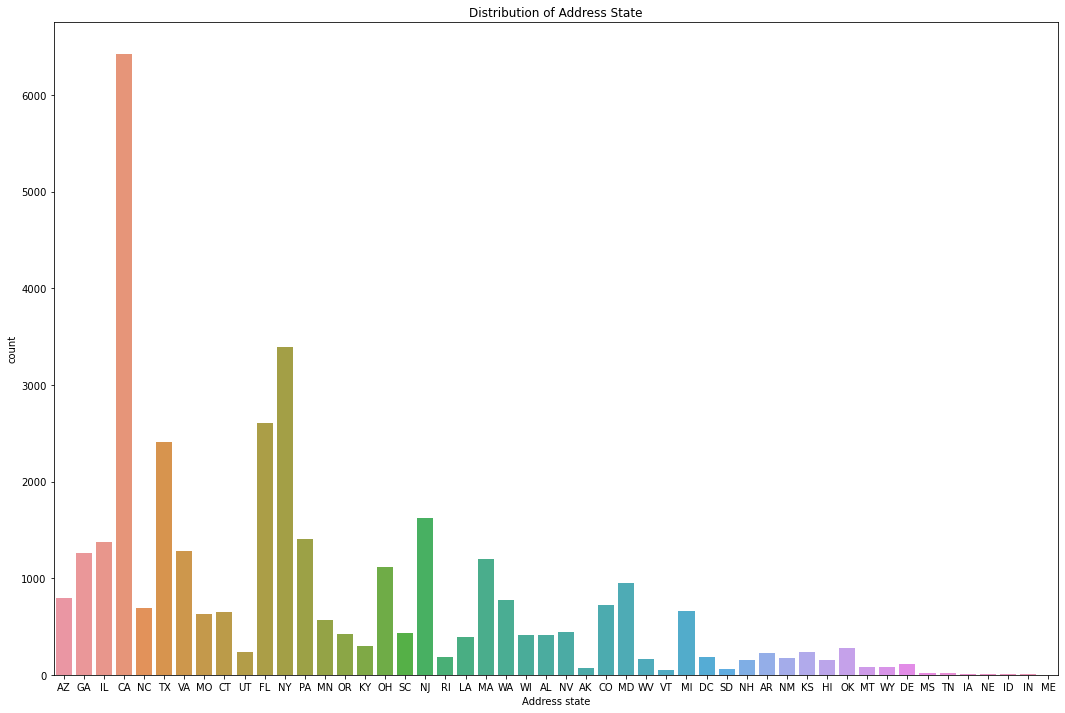

In [47]:
#Description:
    #Borrowers adrress
#univariate:
figure, ax = plt.subplots(nrows=1, figsize=(18,12))
sns.countplot(x='addr_state',data=fdf)
plt.title('Distribution of Address State')
plt.xlabel('Address state')
plt.show()
#conclusion:
    #people from CA are more no of borrowers

### Conclusion drawn about origin state

1. Most of the borrowers taking loans belong to state California(CA), New York(NY) , Florida(FL) and Texas(TX).
2. The above 4 mentioned states can have many industries/income sources or can have high cost of living as a result majority of people borrowing loan belong to the above states.

### Bivariate/Mutlivariate Analysis

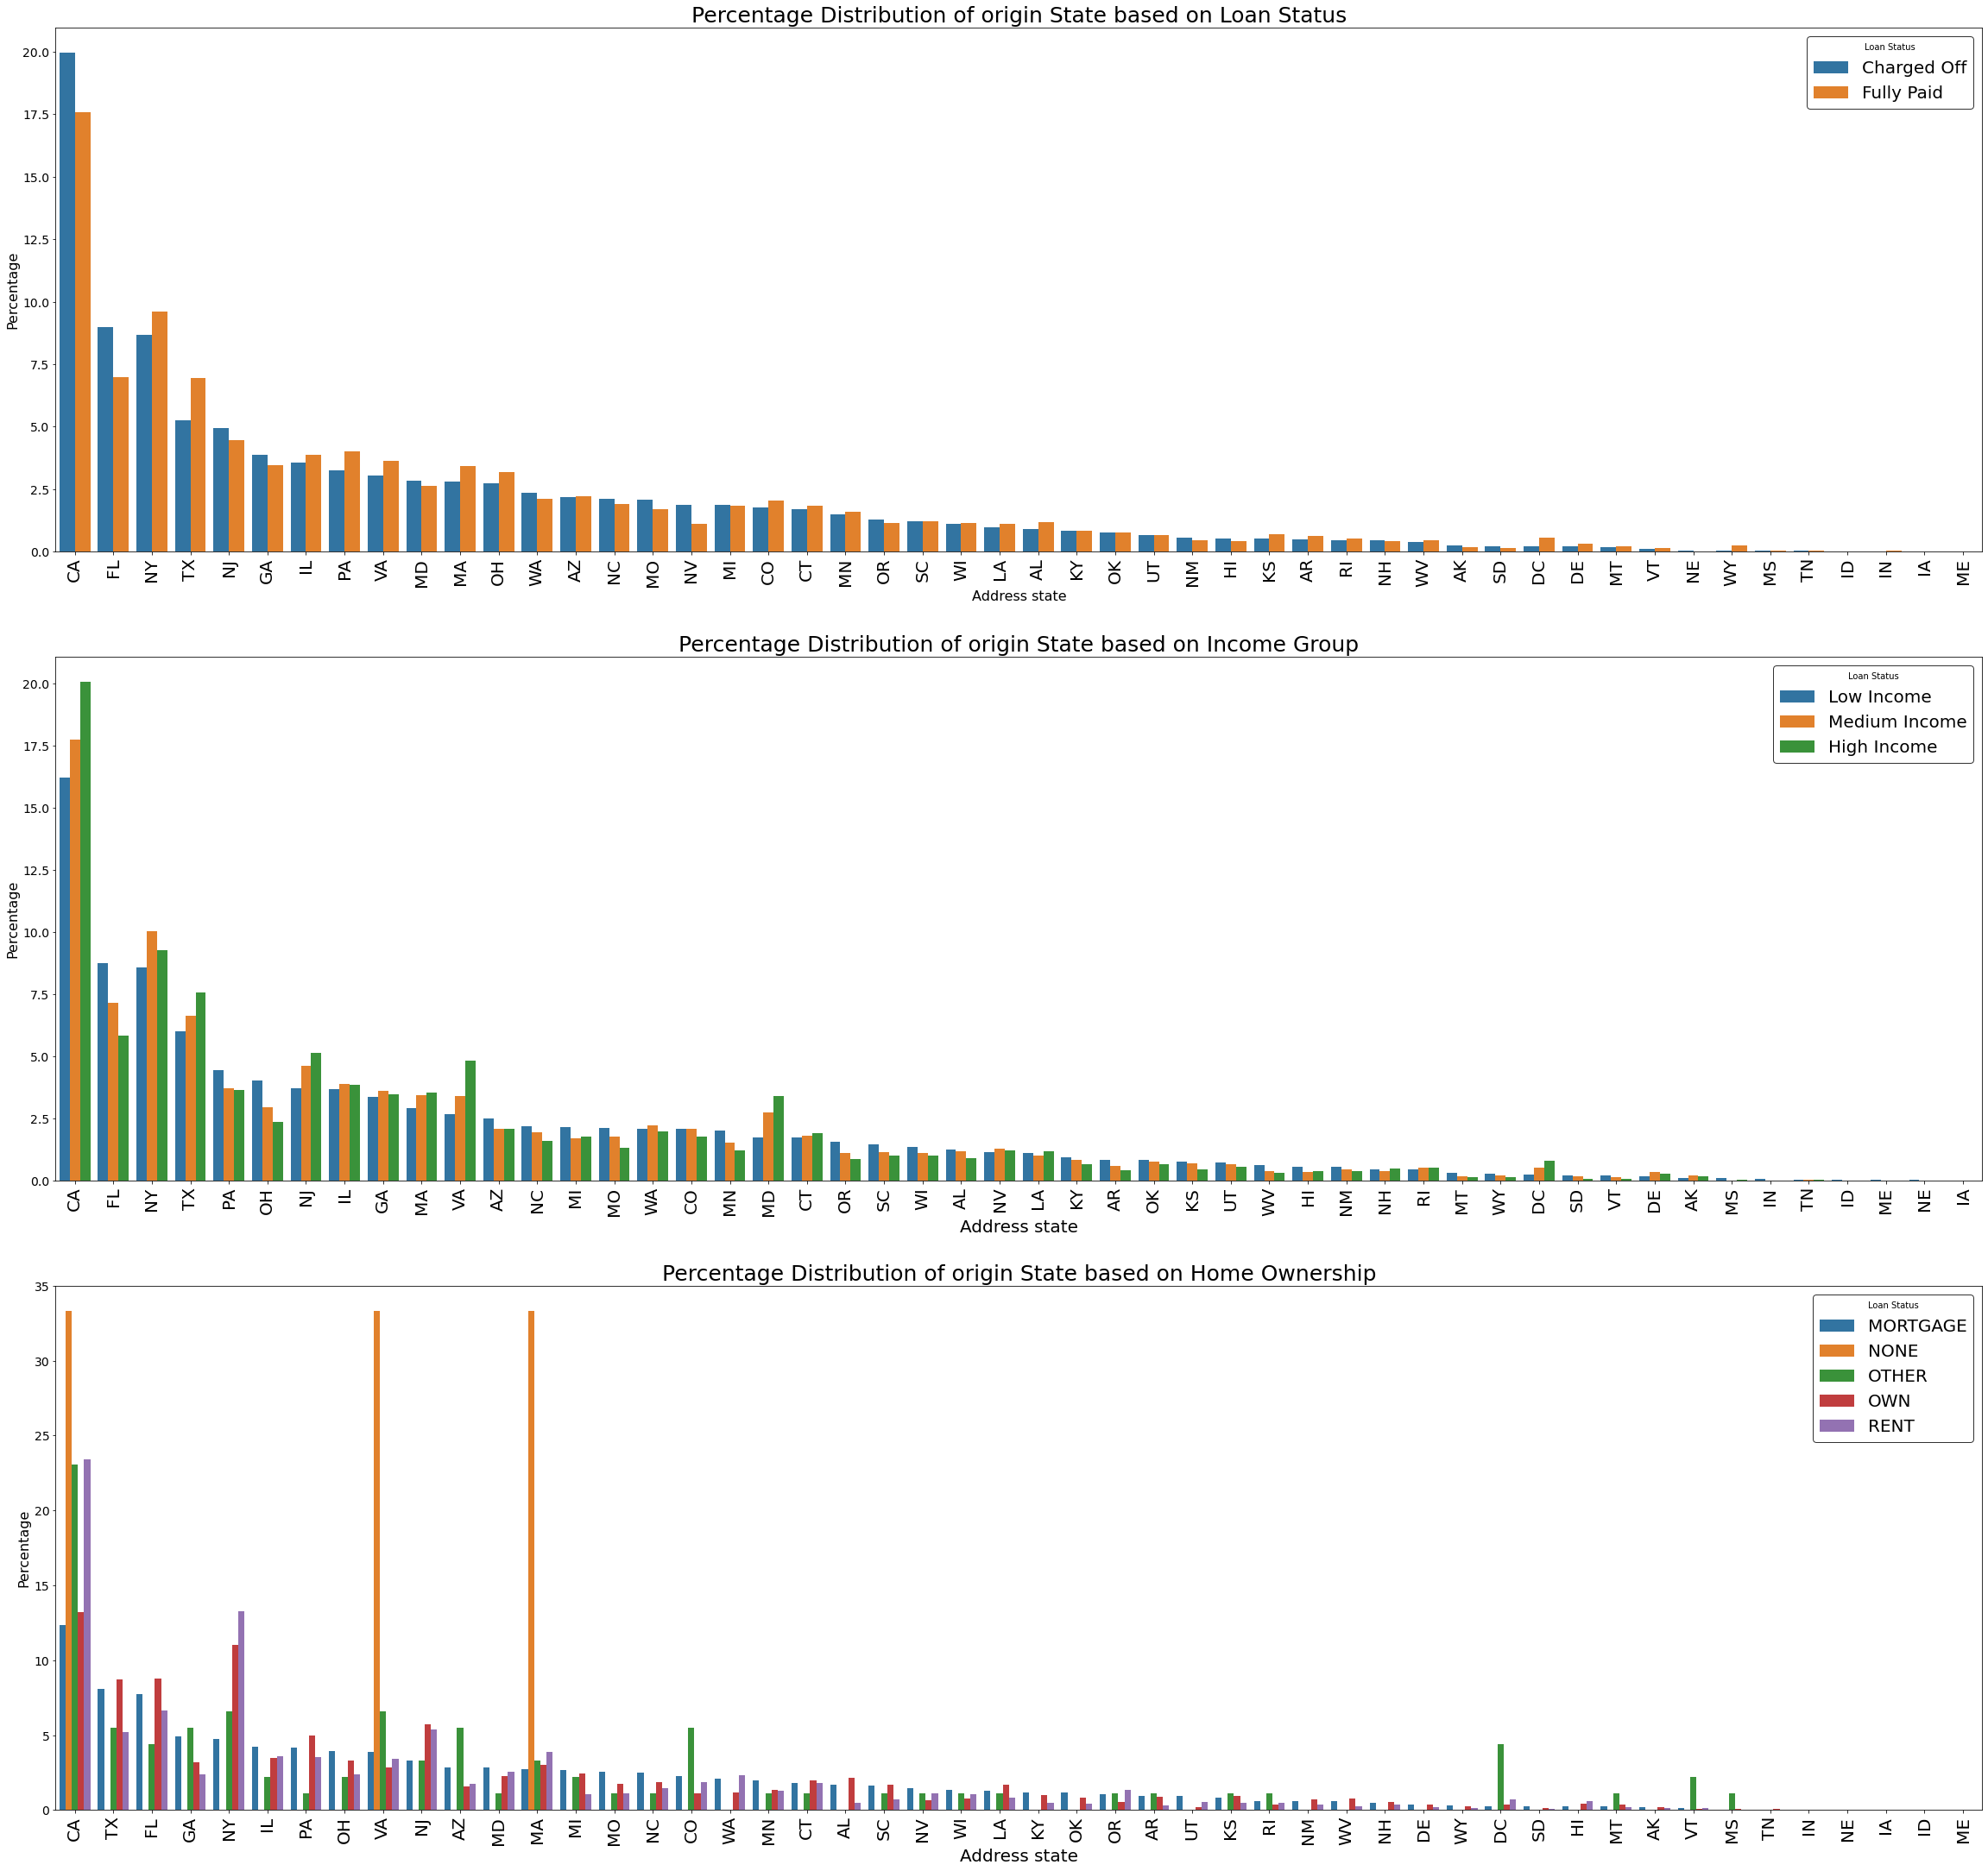

In [74]:
#Bivariate analysis:
figure, ax = plt.subplots(nrows=3, figsize=(40,38))
df1=fdf.groupby('loan_status')['addr_state'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='addr_state',y='percentage',hue='loan_status',data=df1,ax=ax[0])
g.set_title('Barplot on addr_state on basis of loan_status')
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Address state',fontsize=16)
g.set_xticklabels(g.get_xticklabels(),rotation=90,fontsize=20)
g.set_ylabel('Percentage',fontsize=16)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={'size':20})
g.set_title('Percentage Distribution of origin State based on Loan Status',fontsize=25)
#conclusion:
    #Here CA and Fl state having more no of defaulters and belong to low income category
    # A person belonging to FL and low income group will have more chance of defaulting.
df2=fdf.groupby('income_group')['addr_state'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='addr_state',y='percentage',hue='income_group',data=df2,ax=ax[1])
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Address state',fontsize=20)
g.set_ylabel('Percentage',fontsize=16)
g.set_xticklabels(g.get_xticklabels(),rotation=90,fontsize=20)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={'size':20})
g.set_title('Percentage Distribution of origin State based on Income Group',fontsize=25)
#conclusion:
     #Here fl state people having more low income.
df2=fdf.groupby('home_ownership')['addr_state'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='addr_state',y='percentage',hue='home_ownership',data=df2,ax=ax[2])#To remove
g.set_title('Percentage Distribution of origin State based on Home Ownership')
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Address state',fontsize=20)
g.set_xticklabels(g.get_xticklabels(),rotation=90,fontsize=20)
g.set_ylabel('Percentage',fontsize=16)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={'size':20})
g.set_title('Percentage Distribution of origin State based on Home Ownership',fontsize=25)
#conclusion:
    #Here we can see most of people are from state CA are of Rent and None category in home_ownership .
plt.show()

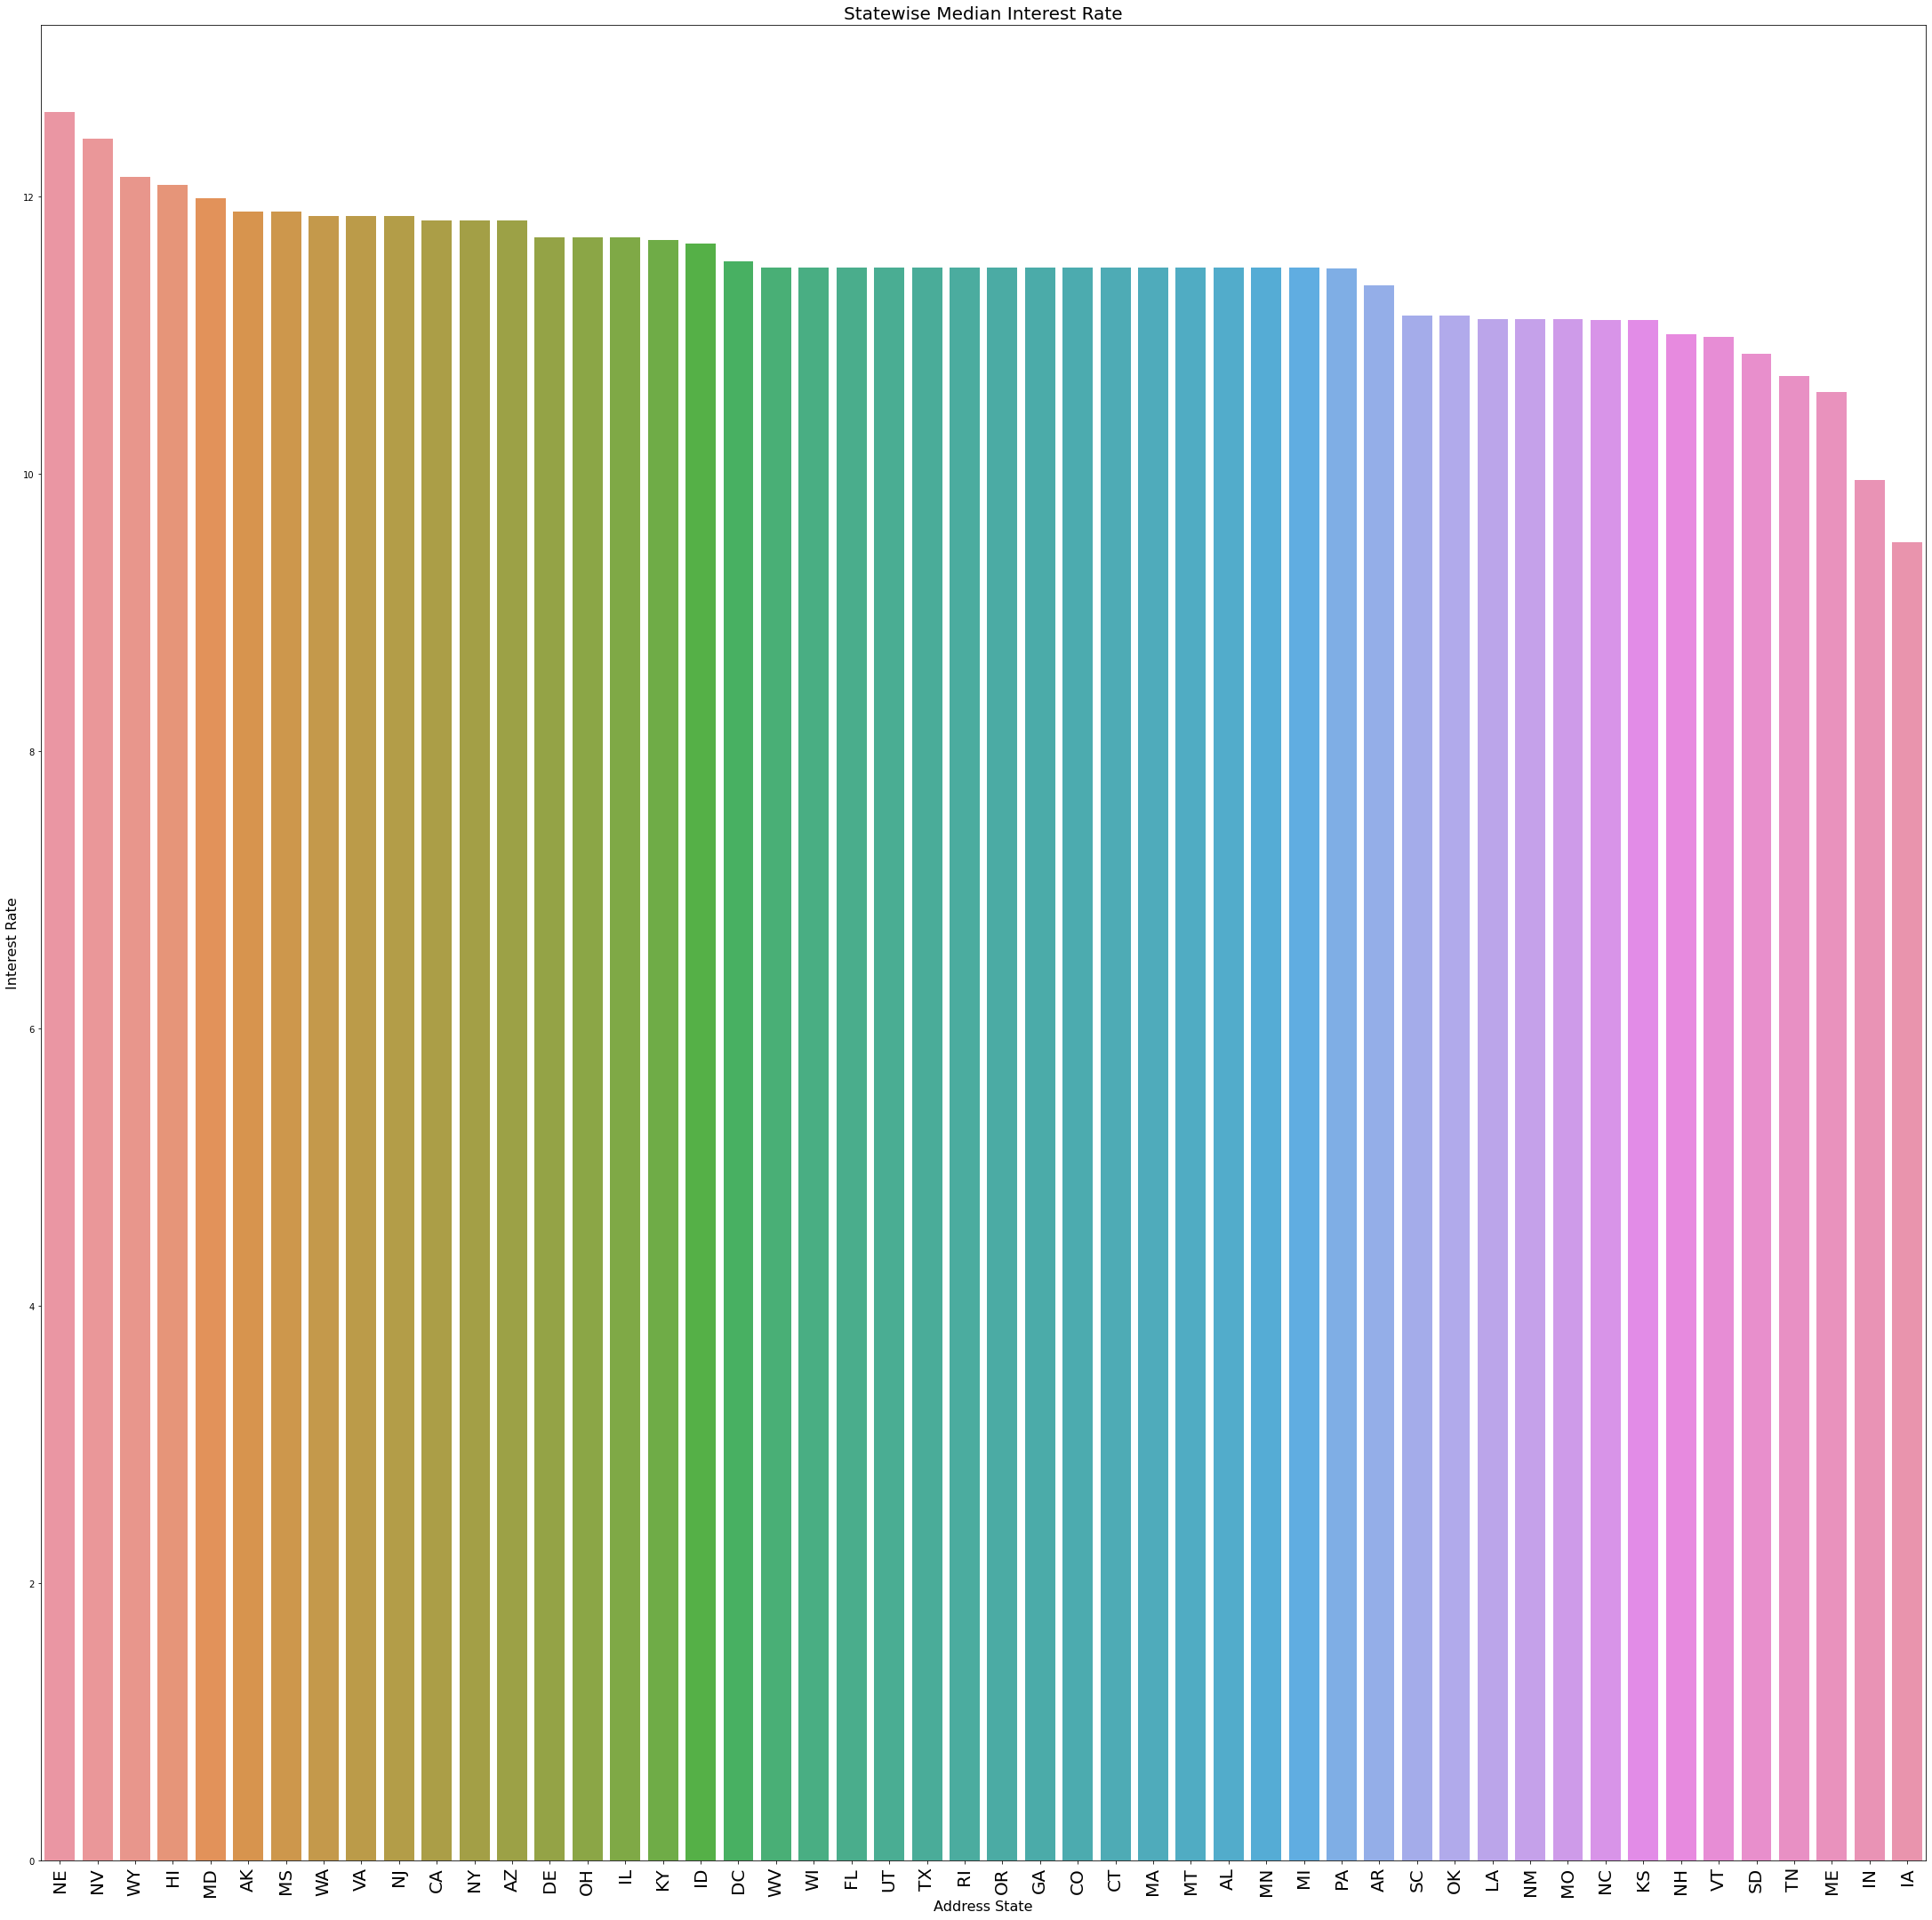

In [49]:
figure, ax = plt.subplots(nrows=1, figsize=(38,38))
df1=fdf.groupby('addr_state')['int_rate'].median().rename('median_int_rate').sort_values(ascending=False).reset_index()
#g=sns.histplot(x='ratio',hue='addr_state',bins=20,kde=False,data=fdf,ax=ax)
g=sns.barplot(x='addr_state',y='median_int_rate',data=df1)
g.set_title('Statewise Median Interest Rate',fontsize=20)
g.set_xticklabels(g.get_xticklabels(),rotation=90,fontsize=20)
g.set_xlabel('Address State',fontsize=16)
g.set_ylabel('Interest Rate',fontsize=16)
plt.show()
#conclusion:
   #People who are belonging to state CA and whose loan to income ratio is between 0.075 to 0.2 are more chance of defaulting

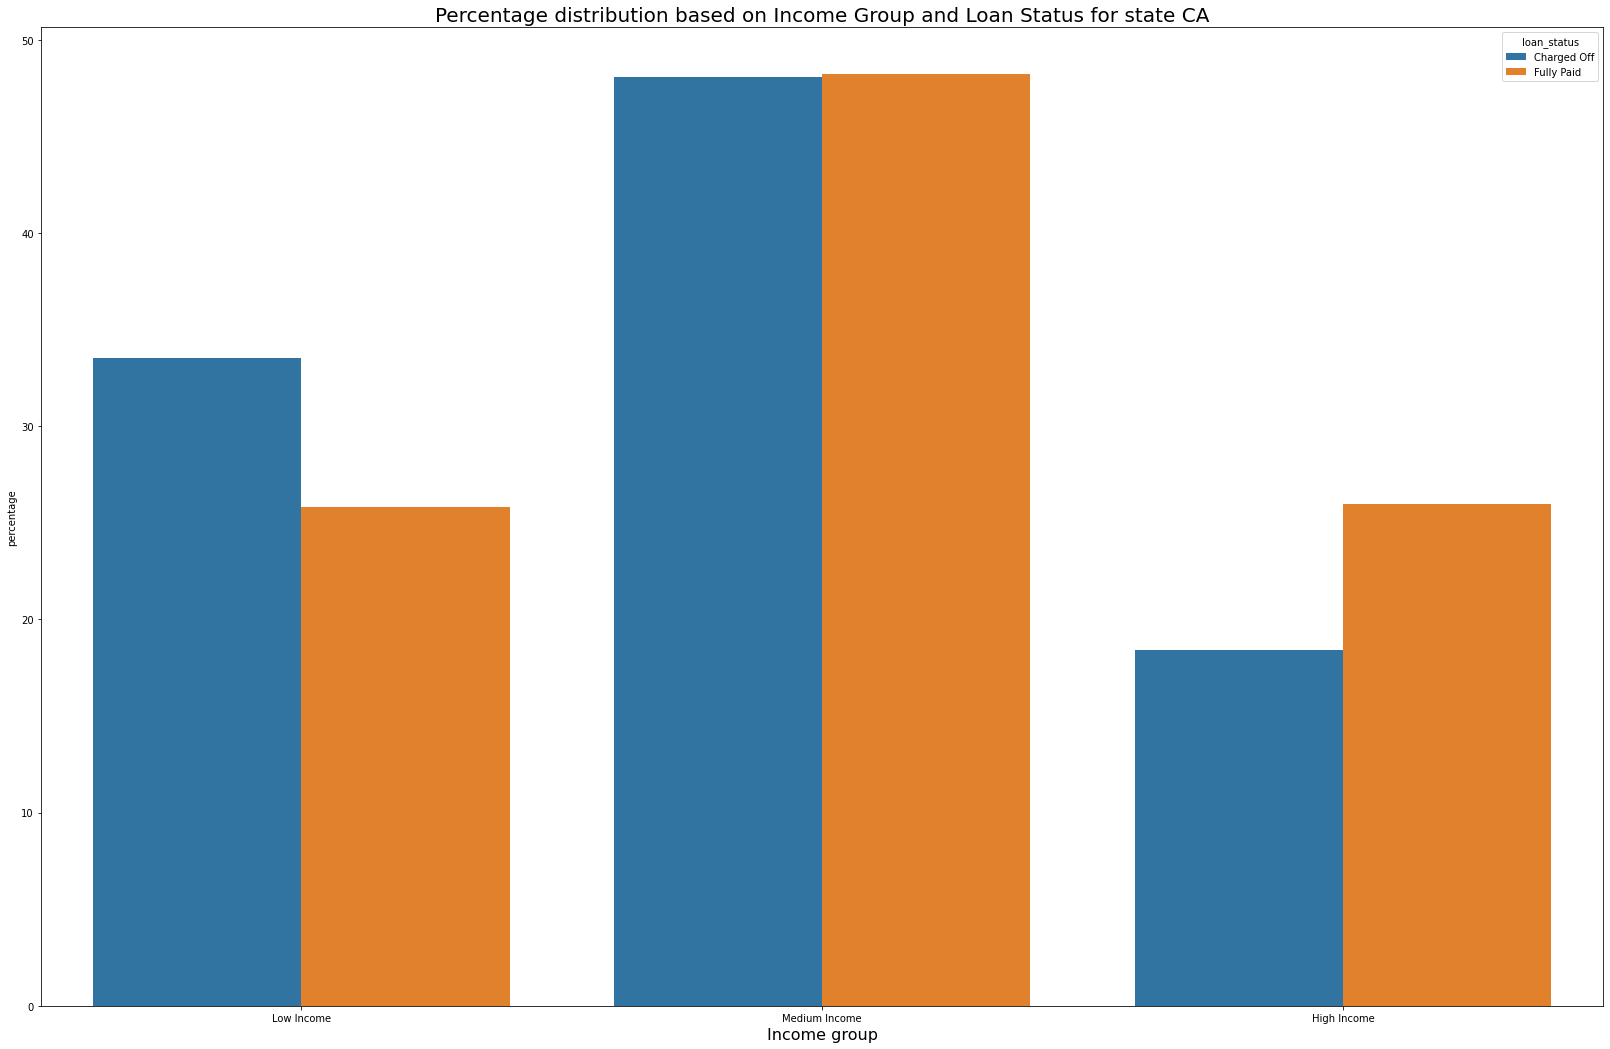

In [50]:
#Trivariate Analysis:
df_ca_state=fdf[fdf['addr_state']=='CA']
fig, ax = plt.subplots(nrows=1, figsize=(28,18))
df2=fdf.groupby('loan_status')['income_group'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()

g2=sns.barplot(x='income_group',y='percentage',hue='loan_status',data=df2)
g2.set_title('Percentage distribution based on Income Group and Loan Status for state CA',fontsize=20)
g2.set_xlabel('Income group',fontsize=16)
g.set_ylabel('Percentage',fontsize=16)
#conclusion:
    #Here People from CA who are having low income are most of defaulters.
plt.show()


### Additional Conclusion drawn about origin state 

1. Borrowers belonging to California(CA) and New York(NY) have more chance of defaulting.
2. In most of the states people belonging to low income group have more chance of defaulting.
3. For state of California the number of borrowers belonging to High Income category is more thus implying it is an Industrial state with many jobs/business and thus having higher income. 
4. The company can increase its profits in states having high number of High Income group borrowers by charging more interest rate. The states are NJ,VA,DC,MD.

# purpose

### Univariate Analysis

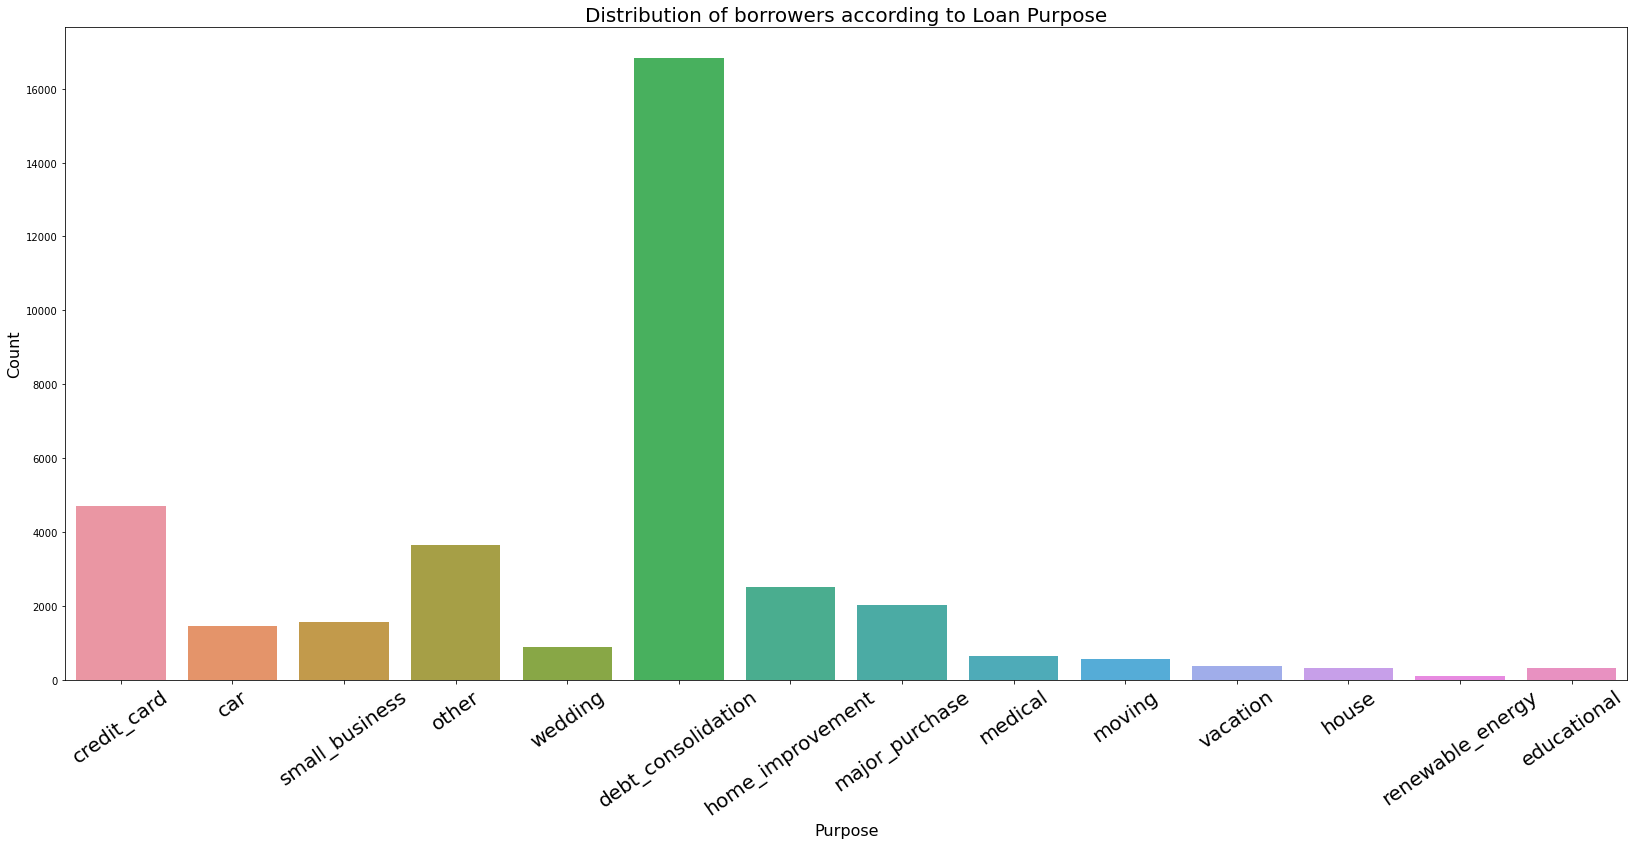

In [51]:
#Description:
      #Reason for why borrowers are taking loan.
#univariate analysis:
fig, ax = plt.subplots(nrows=1, figsize=(28,12))
g=sns.countplot(x='purpose',data=fdf)
g.set_title('Distribution of borrowers according to Loan Purpose',fontsize=20)
g.set_xlabel('Purpose',fontsize=16)
g.set_ylabel('Count',fontsize=16)
g.set_xticklabels(g.get_xticklabels(),rotation=35,fontsize=20)
plt.show()
#conclusion:
   #here people are from debt consolidation are higher.

### Conclusion drawn about Loan Purpose

1. Majority of borrowers are taking loan for purpose of debt consolidation.
2. After debt consolidation, the other major purposes for taking loan are for credit card , small business and home improvement.

### Bivariate/Mutlivariate Analysis

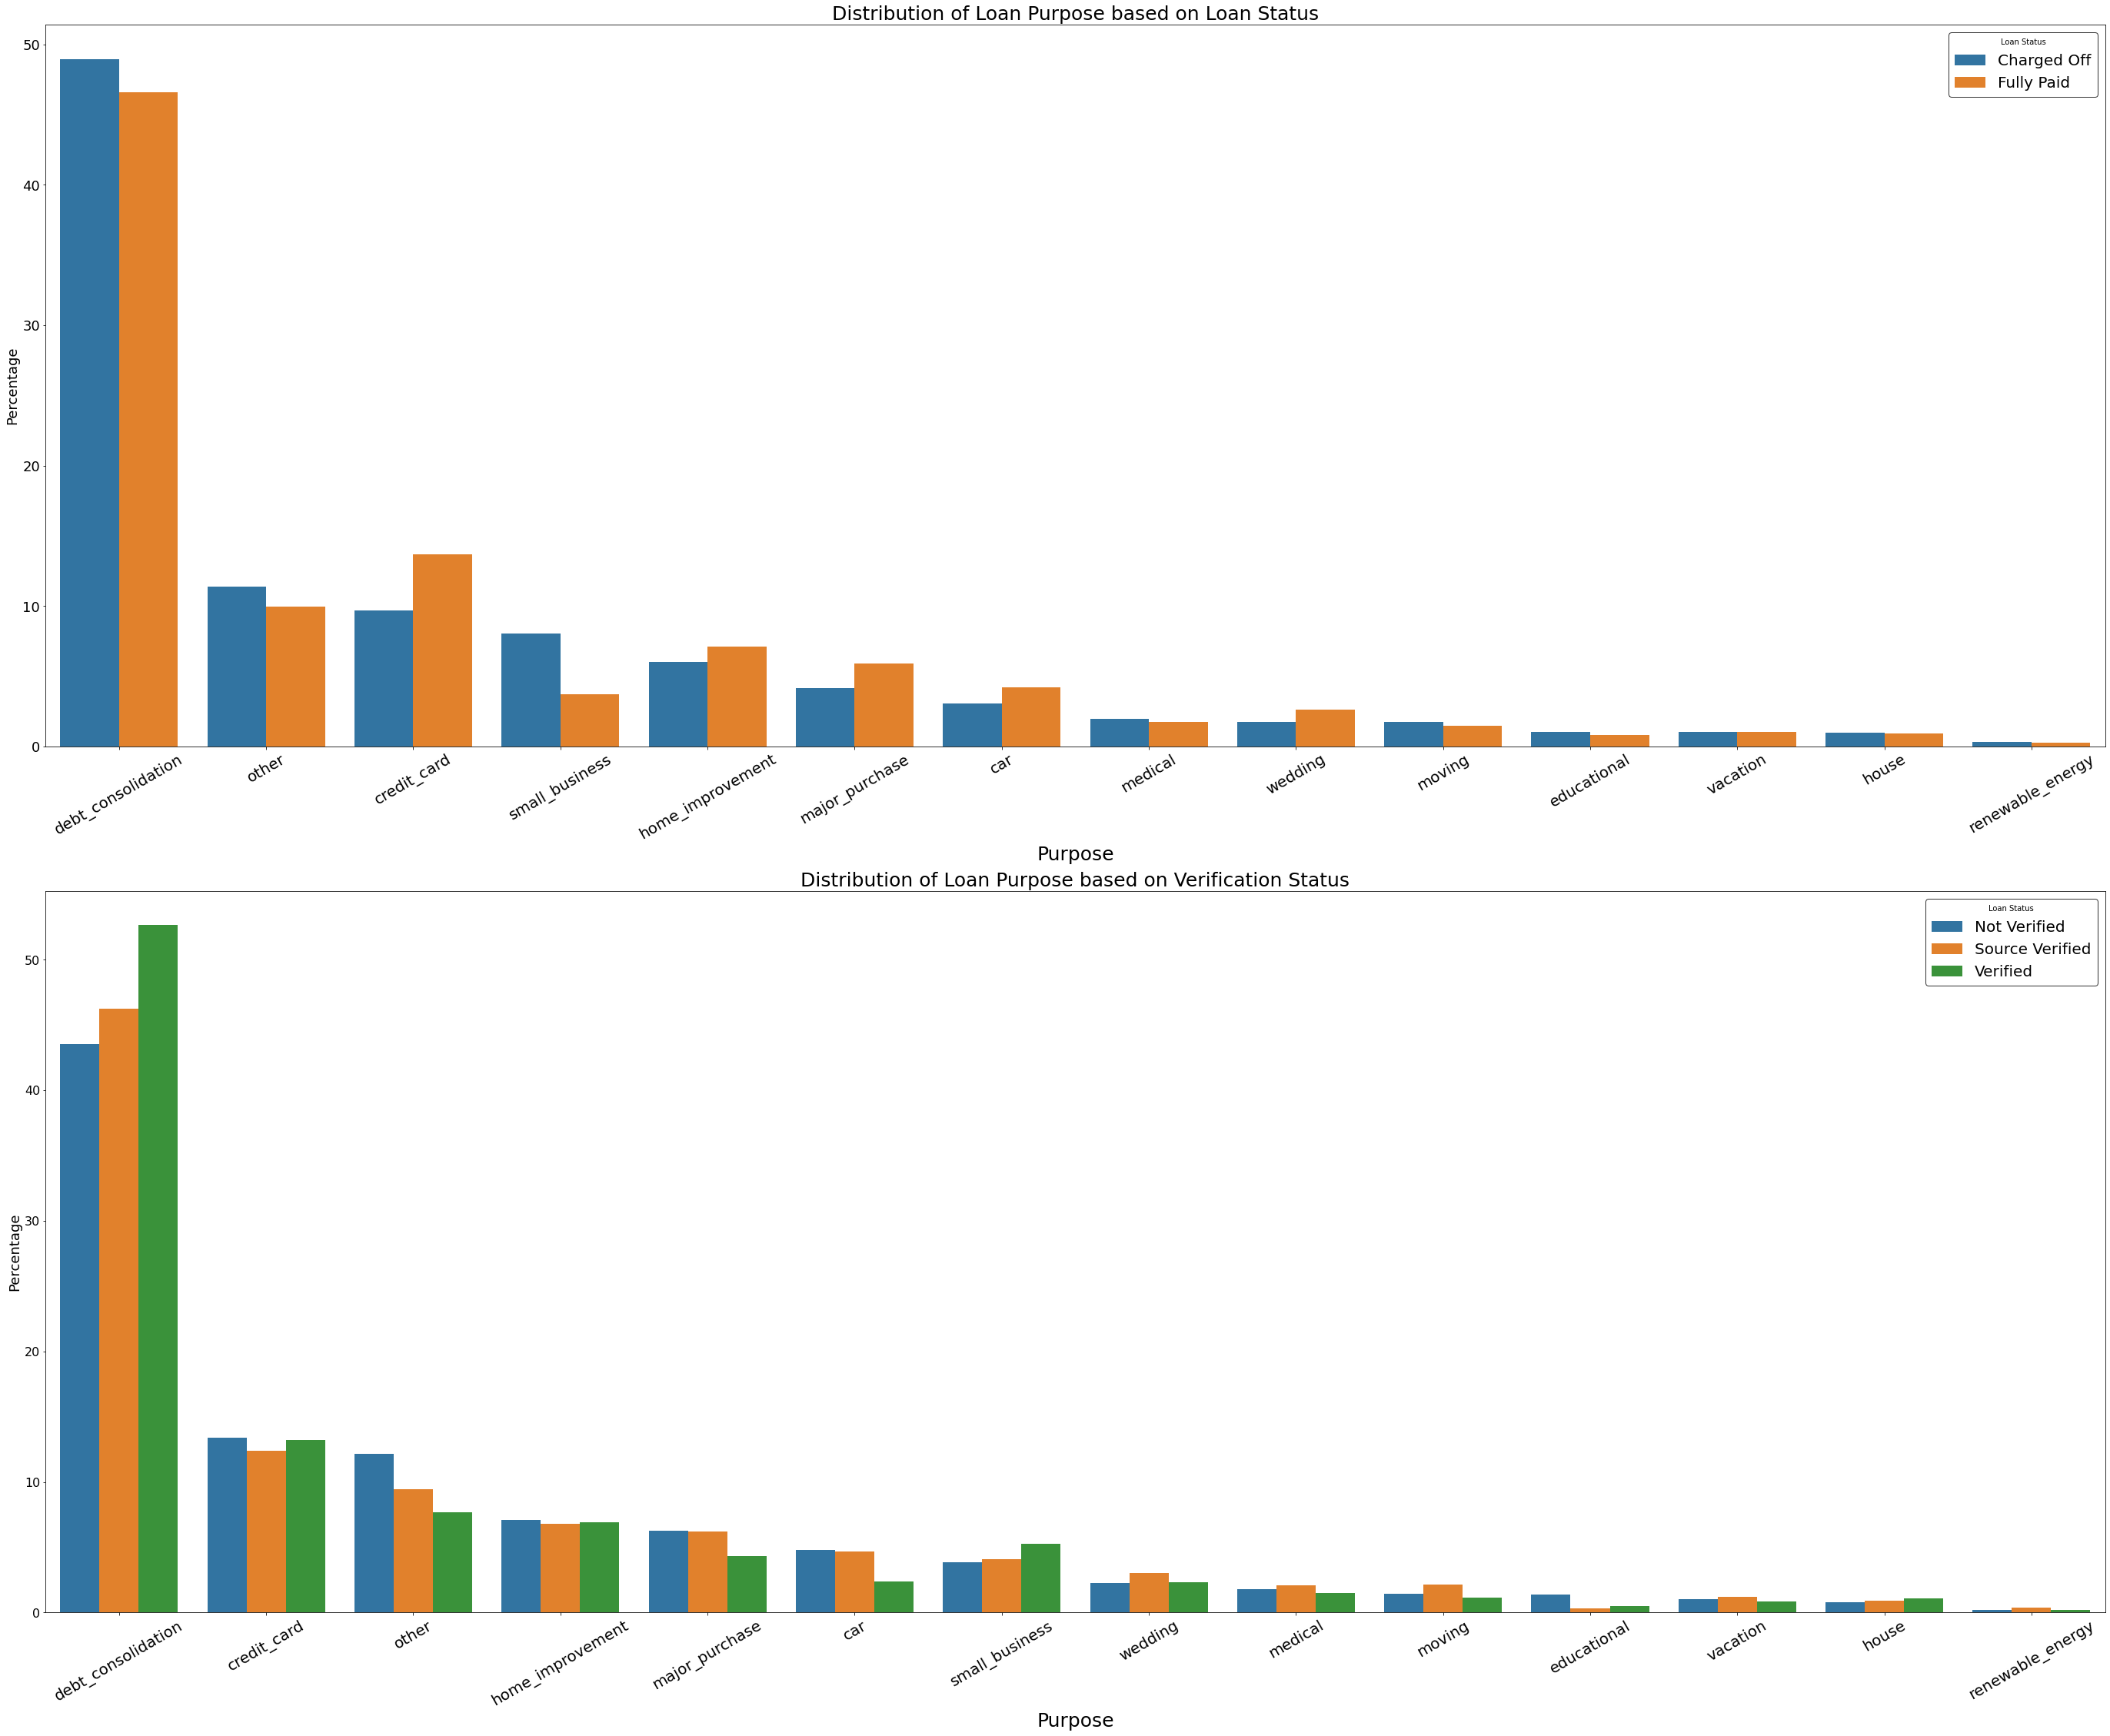

In [75]:
#Bivariate analysis:
fig, ax = plt.subplots(nrows=2, figsize=(48,38))
df1=fdf.groupby('loan_status')['purpose'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='purpose',y='percentage',hue='loan_status',data=df1,ax=ax[0])
g.tick_params(axis='both',labelsize=18)
g.set_xlabel('Purpose',fontsize=25)
g.set_ylabel('Percentage',fontsize=18)
g.set_xticklabels(g.get_xticklabels(),rotation=30,fontsize=20)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={'size':20})
g.set_title('Distribution of Loan Purpose based on Loan Status',fontsize=25)
#conclusion:
     #Most people are taking loan for debt consolodation
     # People taking loan for credit card, small business and other with unverified income source have more chance of defaulting
df2=fdf.groupby('verification_status')['purpose'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='purpose',y='percentage',hue='verification_status',data=df2,ax=ax[1])
g.tick_params(axis='both',labelsize=16)
g.set_xlabel('Purpose',fontsize=25)
g.set_ylabel('Percentage',fontsize=18)
g.set_xticklabels(g.get_xticklabels(),rotation=30,fontsize=20)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={'size':20})
g.set_title('Distribution of Loan Purpose based on Verification Status',fontsize=25)
#conclusion:
     #Here most of not verified are taken loan on debt consolidation and other.
plt.show()

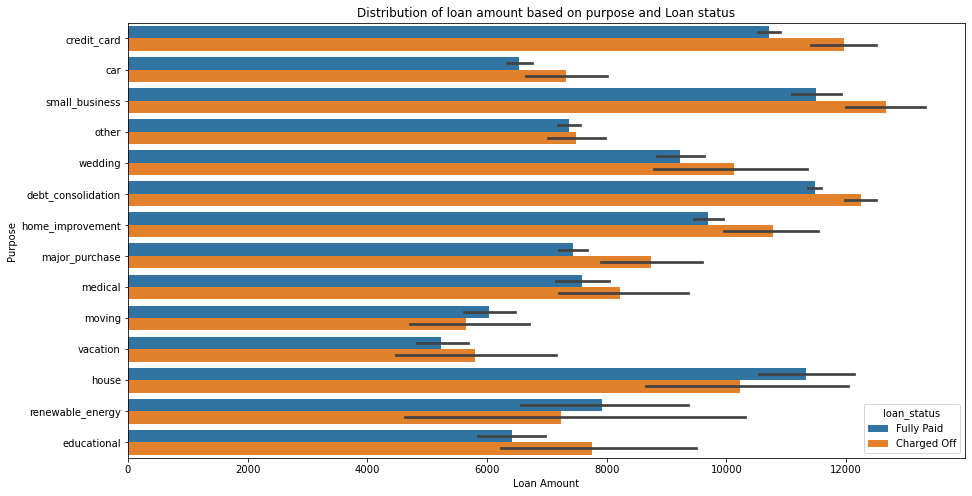

In [53]:
#Trivariate analysis:
plt.figure(figsize = (15,8))
sns.barplot(x='loan_amnt',y='purpose',hue='loan_status',data=fdf)
plt.title('Distribution of loan amount based on purpose and Loan status')
plt.xlabel('Loan Amount')
plt.ylabel('Purpose')
plt.show()
#conclusion:
#1. For lesser loan amounts(<10000), people borrowing for education have more chances of defaulting
#2. For loan amounts (>10000), people borrowing for debt consolidation, credit card, small business have more chances of defaulting 
#3. Higher value current loans are mostly taken for renewable enery. Probably due to goverment subsidy. 

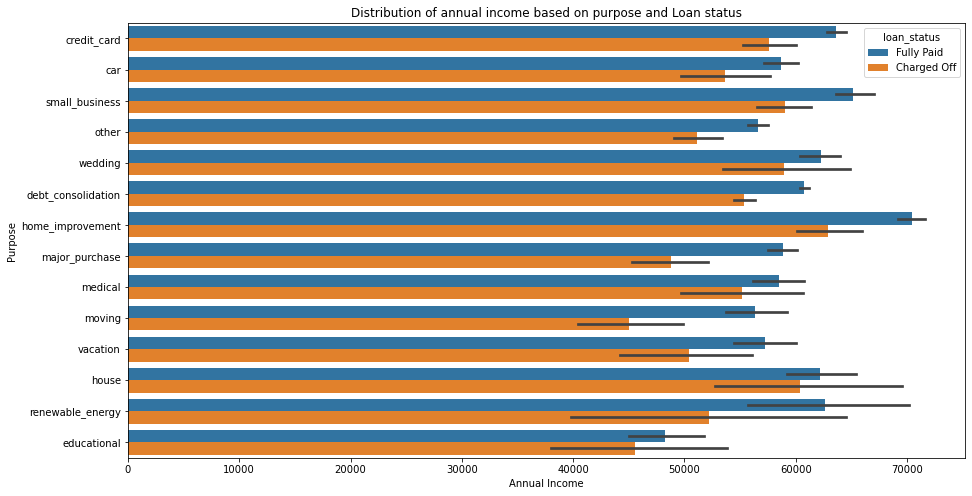

In [54]:
plt.figure(figsize = (15,8))
sns.barplot(x='annual_inc',y='purpose',hue='loan_status',data=fdf)
plt.title('Distribution of annual income based on purpose and Loan status')
plt.xlabel('Annual Income')
plt.ylabel('Purpose')
plt.show()
#conclusion:
   #Here most of defaulters are annual_inc of below 60000 and chances of defaulting above 60000 annual income is very less

### Additional Conclusion drawn about Loan Purpose

1. Borrowers taking loan for debt consolidation and opening small business have more chance of defaulting.
2. Large number of unverified borrowers can be observed who are taking loan for "Other" purpose. These borrowers also have high chance of defaulting. The lender needs to increase verification belonging to this this category in order to reduce chance of defaulting.
3. For categories apart from debt consolidation , debt consolidation and Others, the verification status does not play important role in determining if the borrower will default.
4. For lesser loan amounts lesser than`$`10000, people borrowing for education have more chances of defaulting.
5. For loan amounts greater than `$`10000, people borrowing for debt consolidation, credit card, small business have more chances of defaulting.
6. Borrower belonging to High income category are taking high value loans for renewable energy. This might be due to high subsidy by goverment to push renewable energy utlization.

# Employement length

### Univariate Analysis

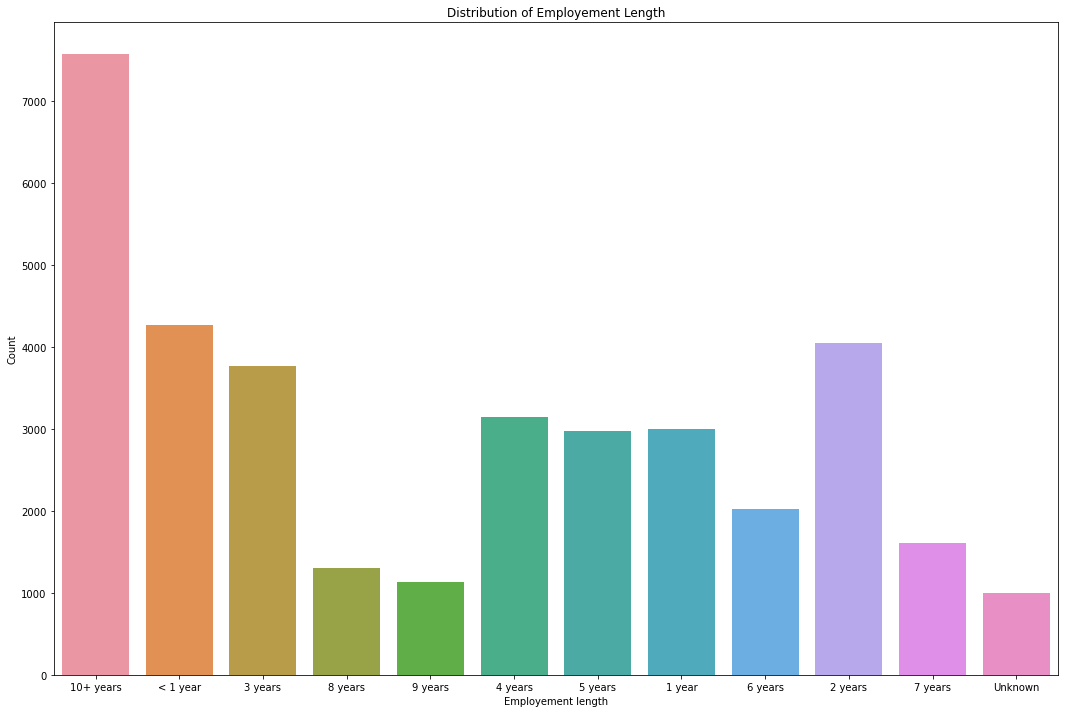

In [55]:
#Description:
     #Length of employees.
#univariate analysis:
figure, ax = plt.subplots(nrows=1, figsize=(18,12))
sns.countplot(x='emp_length',data=fdf)
plt.title('Distribution of Employement Length')
plt.xlabel('Employement length')
plt.ylabel('Count')
plt.show()
#conclusion:
    #Here here people are more from 10years+

### Bivariate/Mutlivariate Analysis

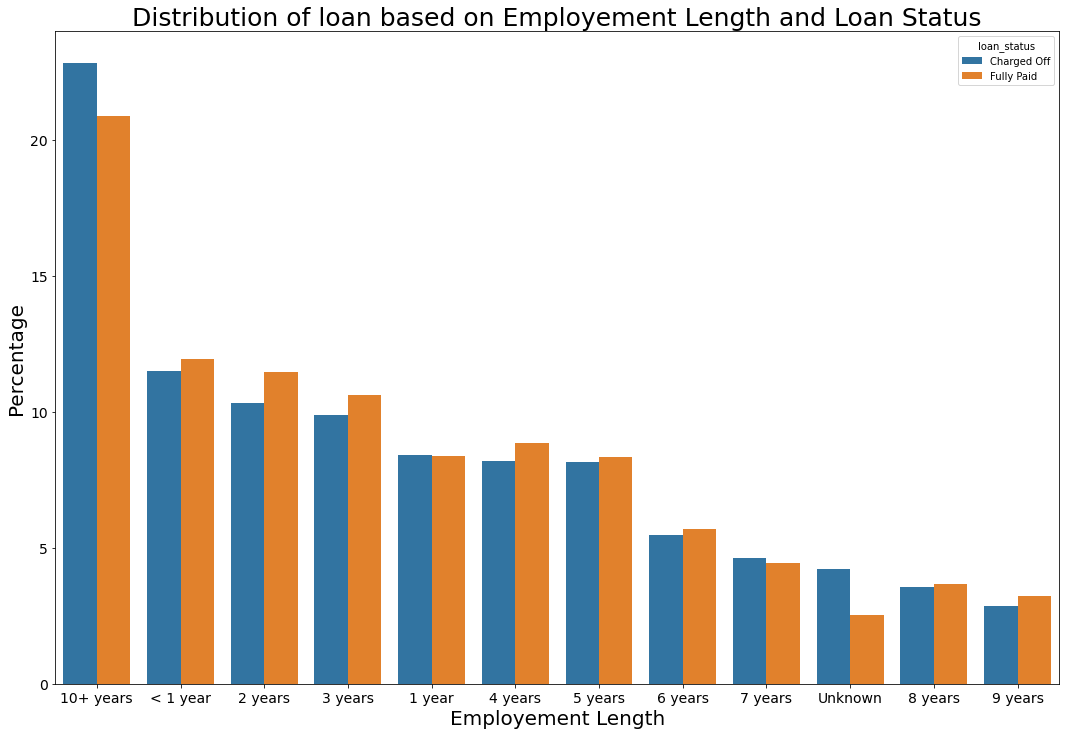

In [56]:
#Bivariate analysis:
figure, ax = plt.subplots(nrows=1, figsize=(18,12))
df1=fdf.groupby('loan_status')['emp_length'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
l=sns.barplot(x='emp_length',y='percentage',hue='loan_status',data=df1)
l.tick_params(axis='both',labelsize=14)
l.set_xlabel('Employement Length',fontsize=20)
l.set_ylabel('Percentage',fontsize=20)
l.set_title('Distribution of loan based on Employement Length and Loan Status',fontsize=25)
#conclusion:
 #Years of expereicne is not playing important factor in determining defaulters
plt.show()

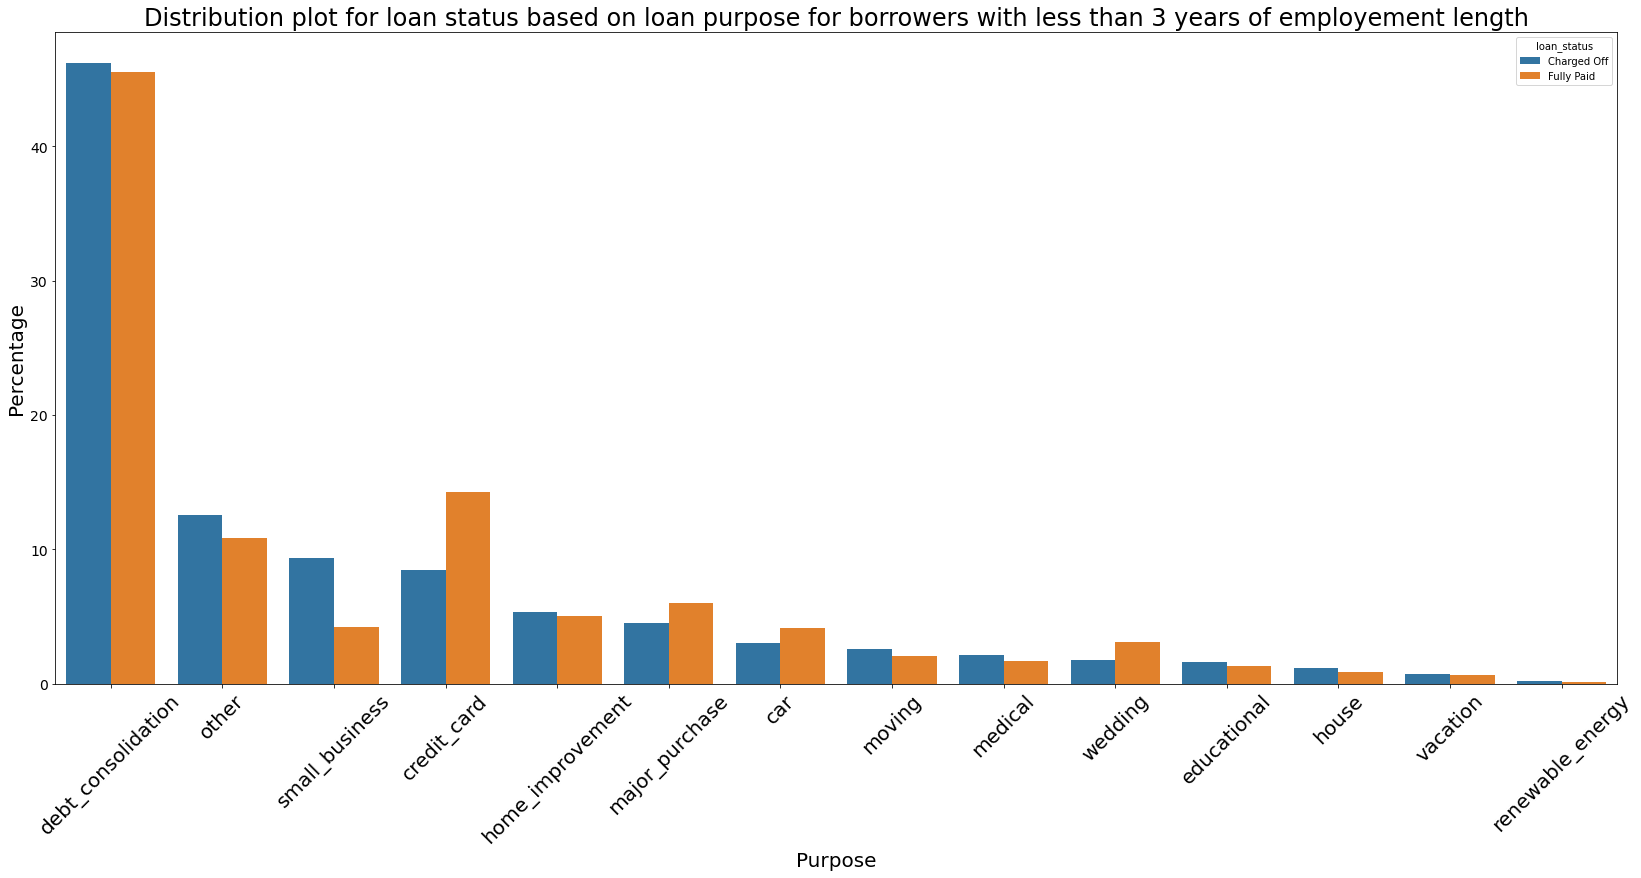

In [57]:
#Bivariate analysis:
df1=fdf[fdf['emp_length'].str.contains('<1 year|1 year|2 years')]
figure, ax = plt.subplots(nrows=1, figsize=(28,12))
df2=df1.groupby('loan_status')['purpose'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
l=sns.barplot(x='purpose',y='percentage',hue='loan_status',data=df2)
l.tick_params(axis='both',labelsize=14)
l.set_xlabel('purpose',fontsize=20)
l.set_ylabel('Percentage',fontsize=20)
plt.xlabel('Purpose')
l.set_xticklabels(l.get_xticklabels(),rotation=45,fontsize=20)
l.set_title('Distribution plot for loan status based on loan purpose for borrowers with less than 3 years of employement length',fontsize=24)
#conclusion:
 #Years of expereicne is not playing important factor in determining defaulters
plt.show()

### Conclusion drawn about Employement Length

1. Most of the borrowers taking loan have 10+ years of employement.
2. Based on years of employement length one cannot predict if the borrower is going to default.
3. Loan taken for debt consolidation is high among borrowers having emploement length of less than 3 years.

# Verification status

### Univariate Analysis

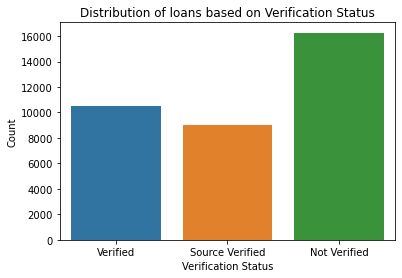

In [58]:
#Description:
    #This columns shows if the credit limit of borrowers are verified or not.
#univariate analysis:
sns.countplot(x='verification_status',data=fdf)
plt.title('Distribution of loans based on Verification Status')
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.show()
#conclusion:
    #Here it shows that most of borrowers cl is not verified.

### Bivariate/Mutlivariate Analysis

Text(0.5, 1.0, 'Distribution of loans based on Verification Status and Loan Status')

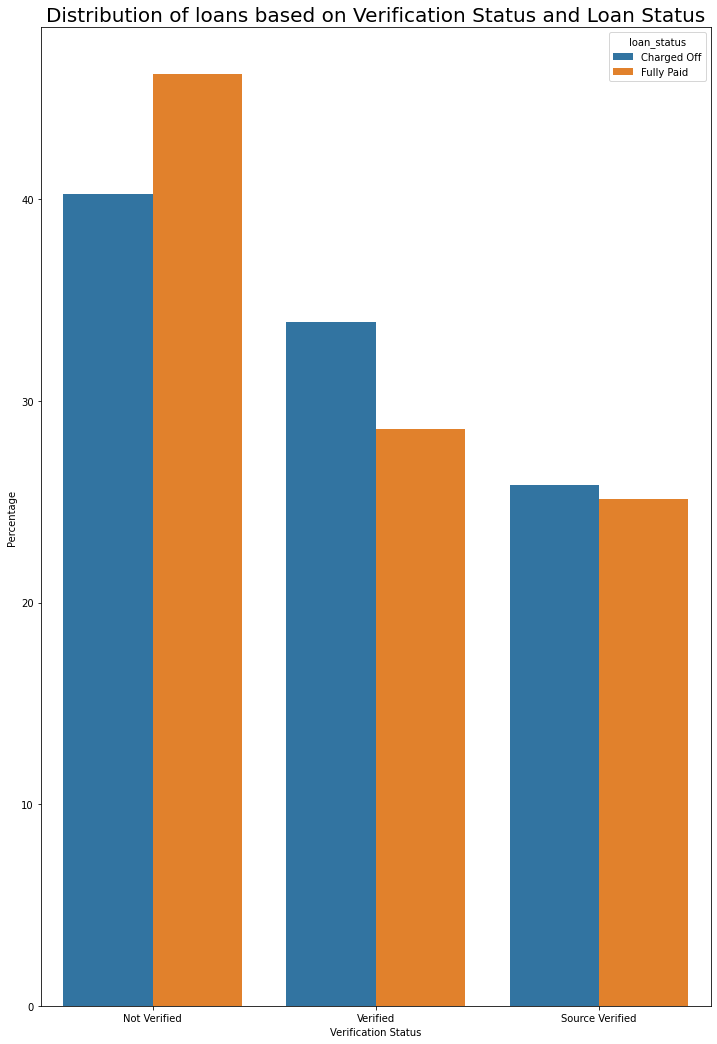

In [59]:
#Bivariate analysis:
figure, ax = plt.subplots(nrows=1,figsize=(12,18))
df3=fdf.groupby('loan_status')['verification_status'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
l=sns.barplot(x='verification_status',y='percentage',hue='loan_status',data=df3)
l.tick_params(axis='both',labelsize=10)
l.set_xlabel('Verification Status',fontsize=10)
l.set_ylabel('Percentage',fontsize=10)
l.set_title('Distribution of loans based on Verification Status and Loan Status',fontsize=20)
#conclusion:
   # Here we get that the borrowers whose credit limit has been verified are most of defaulters compare the fully paid.

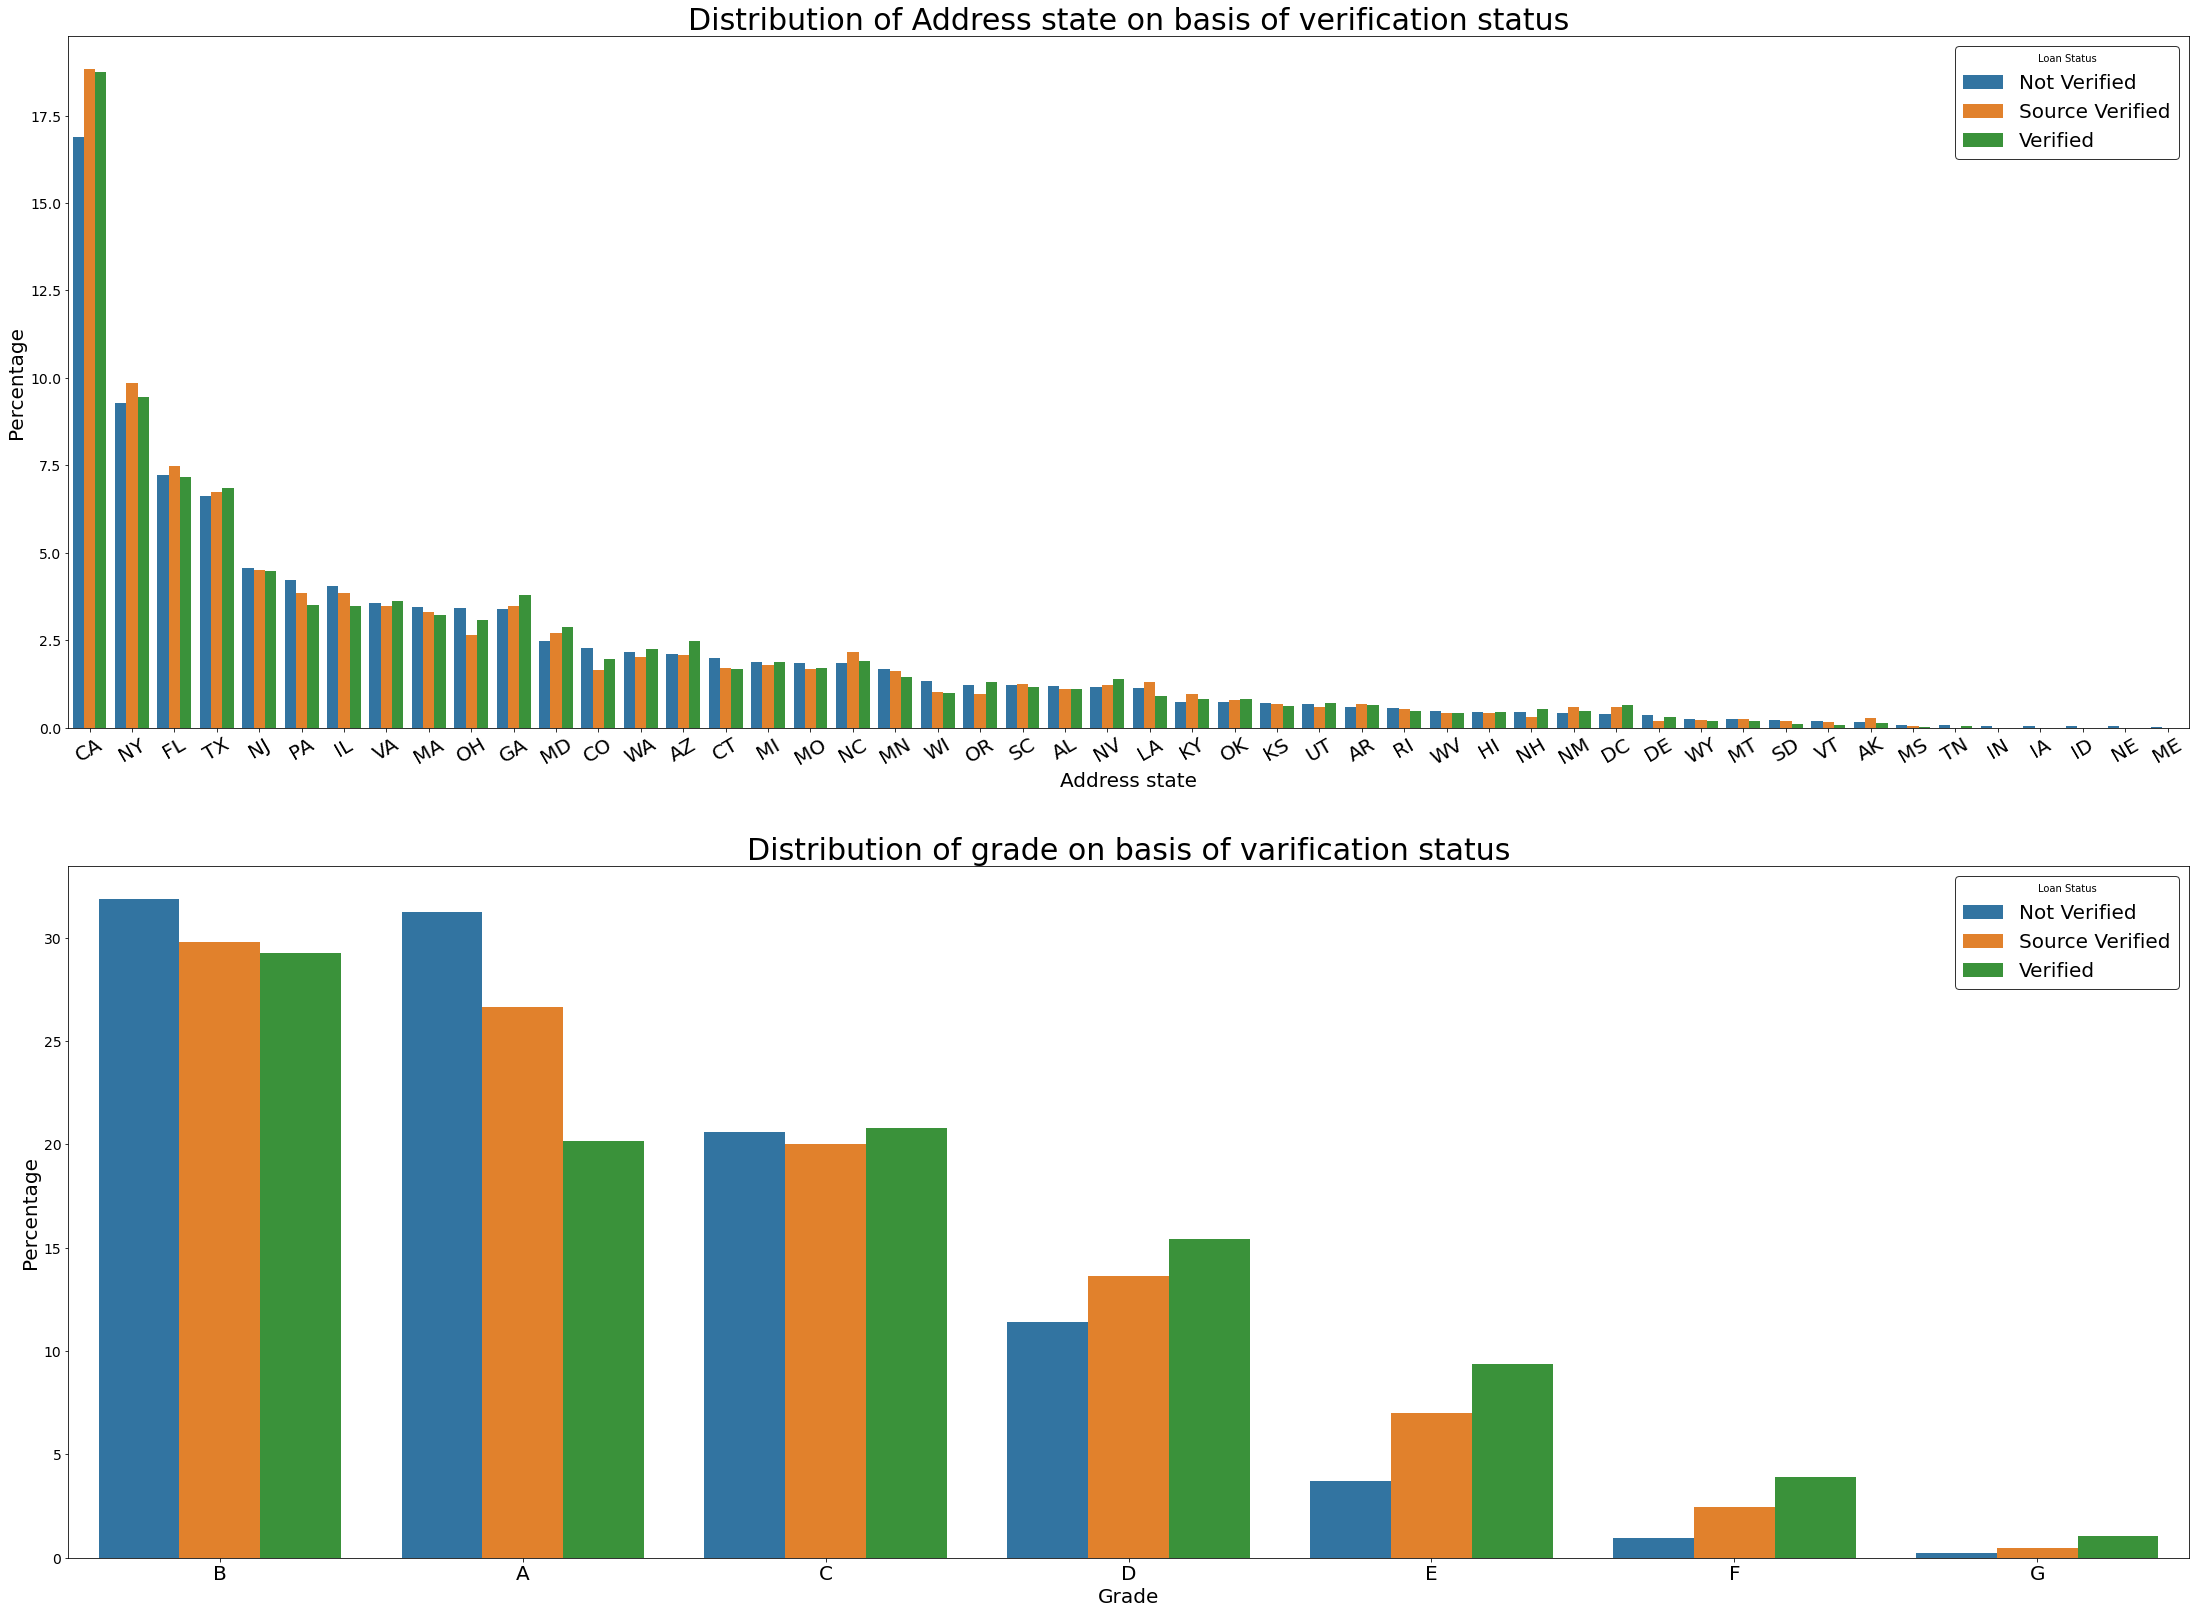

In [60]:
figure, ax = plt.subplots(nrows=2, figsize=(38,28))
df1=fdf.groupby('verification_status')['addr_state'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='addr_state',y='percentage',hue='verification_status',data=df1,ax=ax[0])
g.tick_params(axis='both',labelsize=14)
g.set_xlabel('Address state',fontsize=20)
g.set_ylabel('Percentage',fontsize=20)
g.set_xticklabels(g.get_xticklabels(),rotation = 30,fontsize=20)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={'size':20})
g.set_title('Distribution of Address state on basis of verification status',fontsize=30)
#conclusion:
   # Most verified borrowers are fron CA state.
df2=fdf.groupby('verification_status')['grade'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
l=sns.barplot(x='grade',y='percentage',hue='verification_status',data=df2,ax=ax[1])
l.tick_params(axis='both',labelsize=14)
l.set_xlabel('Grade',fontsize=20)
l.set_ylabel('Percentage',fontsize=20)
l.legend(title='Loan Status',edgecolor='black',loc=1,prop={'size':20})
l.set_xticklabels(l.get_xticklabels(),fontsize=20)
l.set_title('Distribution of grade on basis of varification status',fontsize=30)
#conclusion:
   #Here people from grade B and A are mostly not verified.
   ##Overallall: Verification criteria is not able to determine if the loan will have higher chance of defaulting.
plt.show()

### Conclusion drawn about Verification status

1. Verification status of person may not be able to predict if a person is likely to default.
2. Borrowers belonging to grade C,D and E are more likely to default even though their status is verified.
3. In contrast we observed persons belonging to Grade A,B are less likely to default even though they have more number of unverified status.

# Zip code

### Bivariate/Mutlivariate Analysis

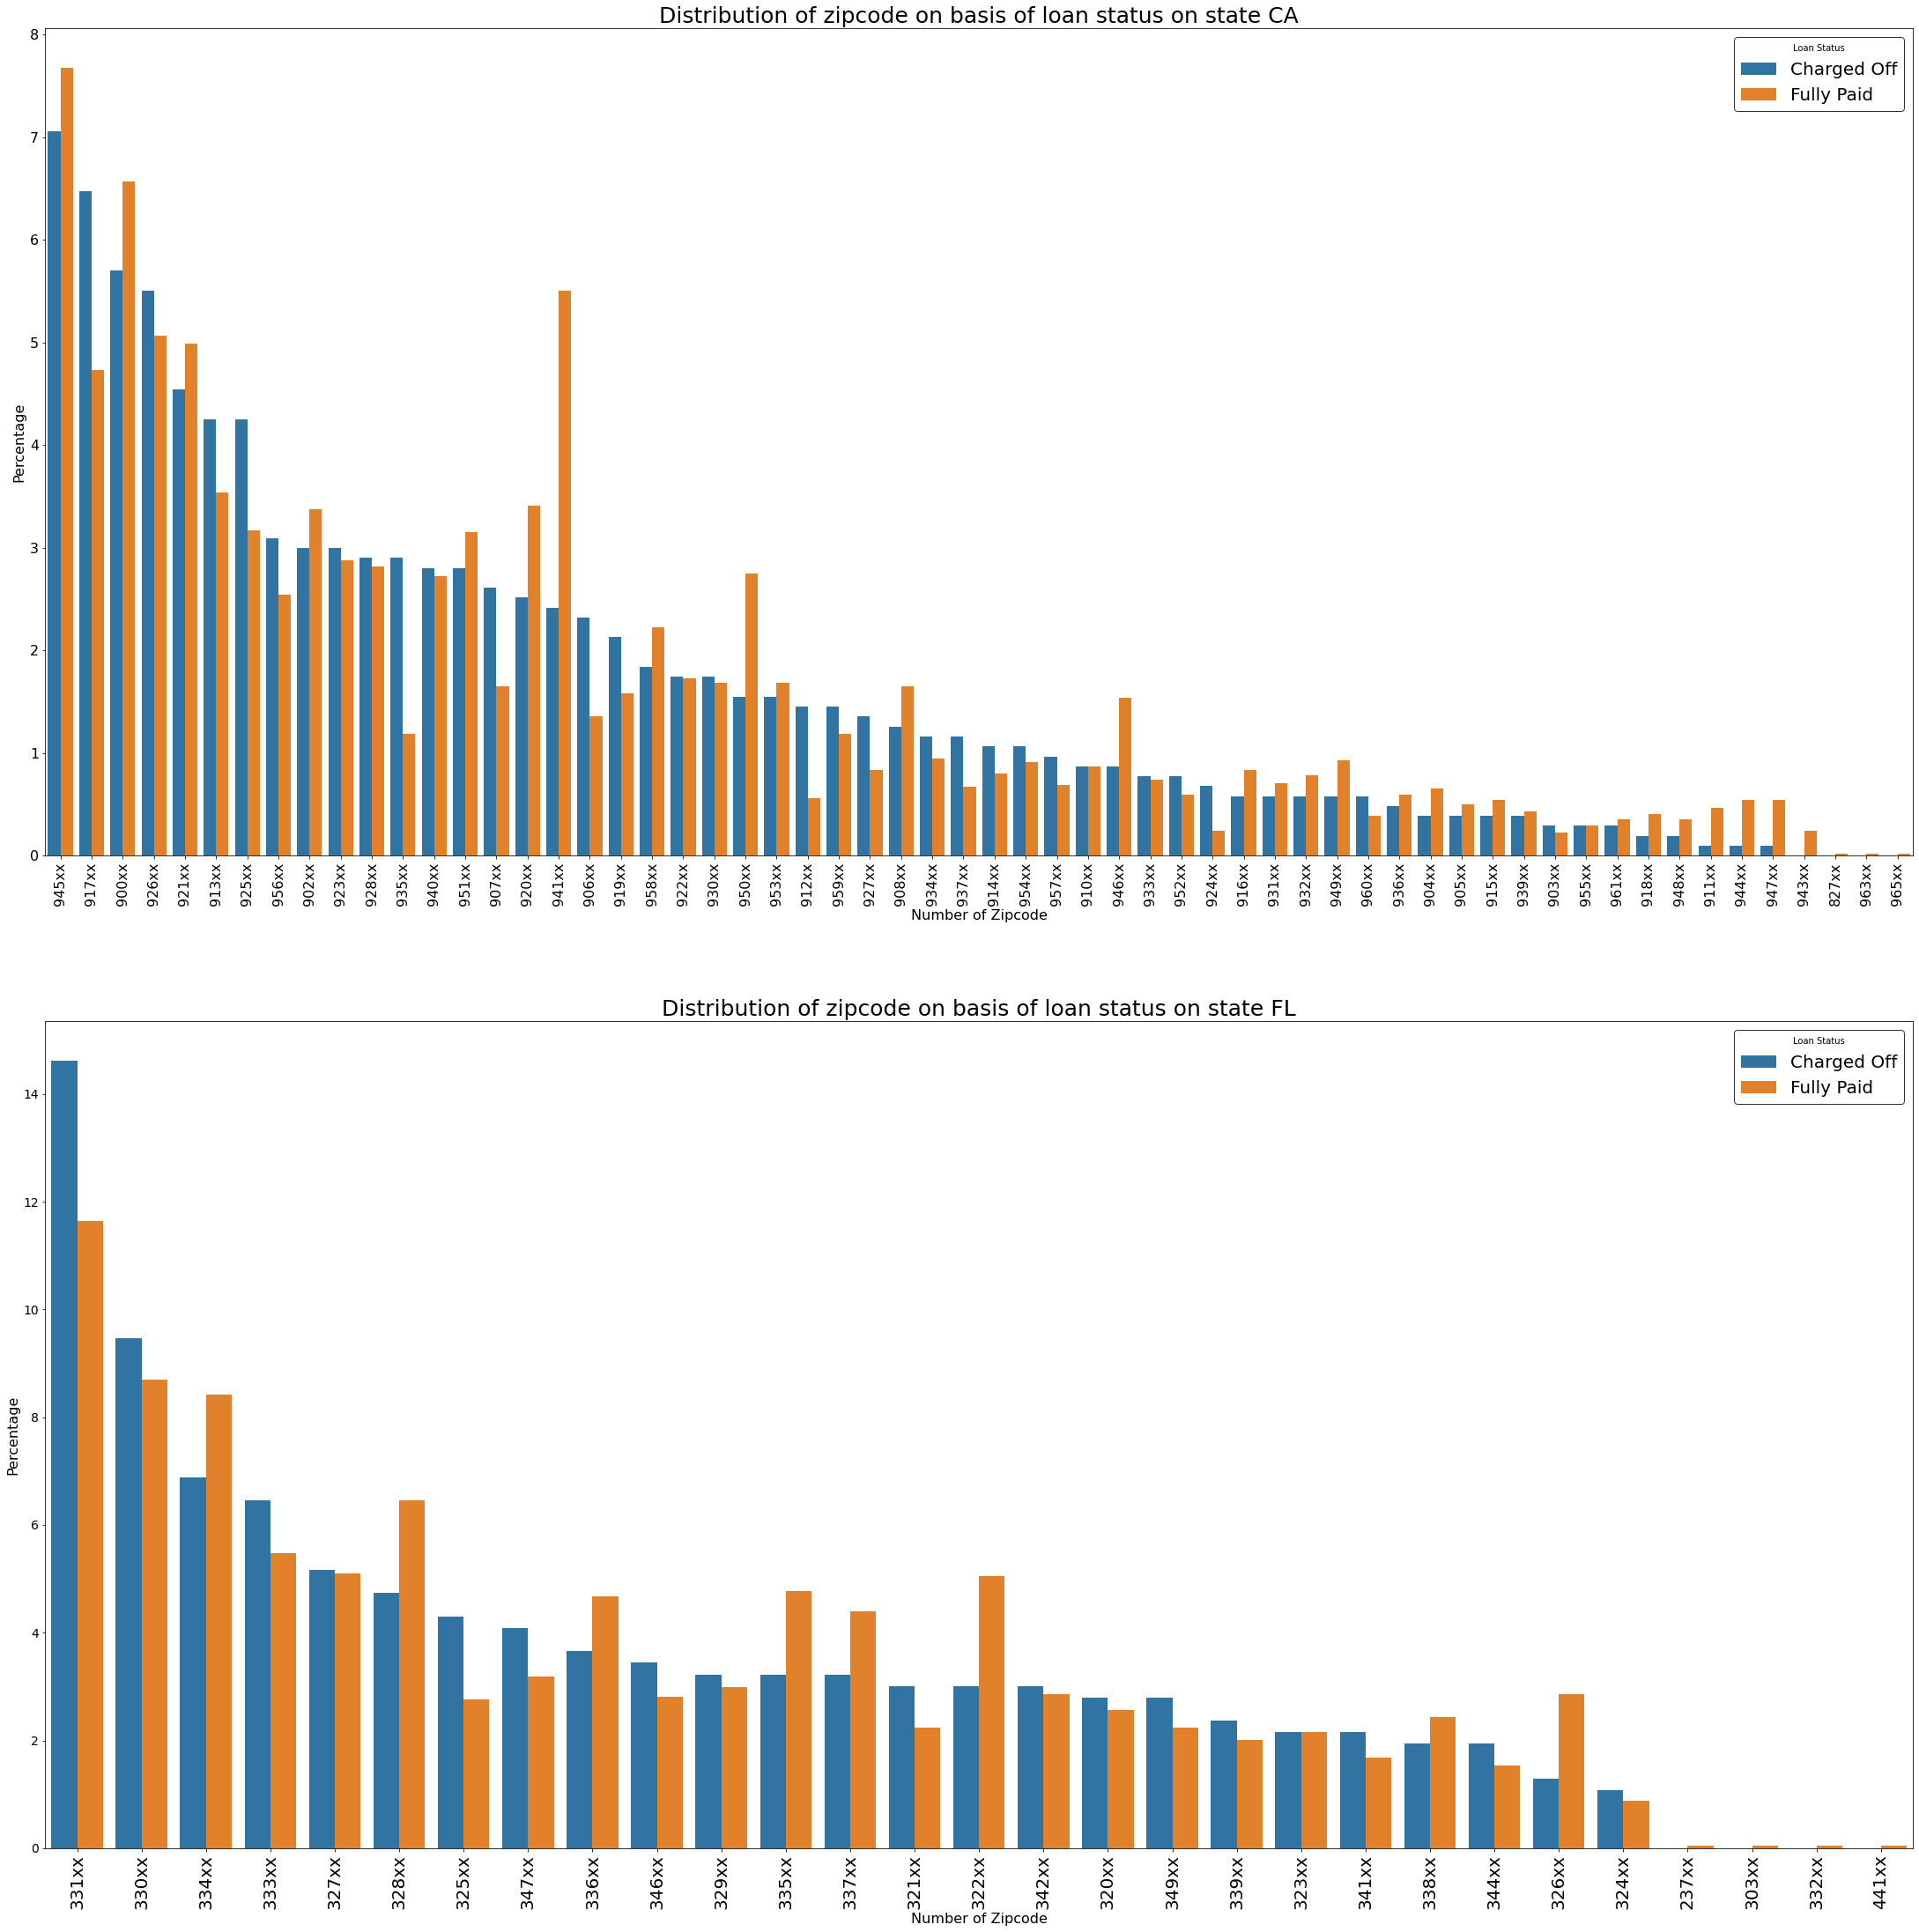

In [61]:
#Description:
    #zip_code provided in borrowers file.
#Bivariate analysis:
figure, ax = plt.subplots(nrows=2,figsize=(38,38))
df1 = fdf[fdf['addr_state']=='CA']
df2=df1.groupby('loan_status')['zip_code'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
g=sns.barplot(x='zip_code',y='percentage',hue='loan_status',data=df2,ax=ax[0])
g.set_xticklabels(g.get_xticklabels(),rotation = 90,fontsize=20)
g.set_title('Distribution of zipcode on basis of loan status for state CA')
g.tick_params(axis='both',labelsize=16)
g.set_xlabel('Number of Zipcode',fontsize=16)
g.set_ylabel('Percentage',fontsize=16)
g.legend(title='Loan Status',edgecolor='black',loc=1,prop={'size':20})
g.set_title('Distribution of zipcode on basis of loan status on state CA',fontsize=25)
df3 = fdf[fdf['addr_state']=='FL']
df4=df3.groupby('loan_status')['zip_code'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
h=sns.barplot(x='zip_code',y='percentage',hue='loan_status',data=df4)
h.set_title('Distribution of zipcode on basis of loan status for state FL')
h.tick_params(axis='both',labelsize=14)
h.set_xticklabels(h.get_xticklabels(),rotation = 90,fontsize=20)
h.set_xlabel('Number of Zipcode',fontsize=16)
h.set_ylabel('Percentage',fontsize=16)
h.set_title('Distribution of zipcode on basis of loan status on state FL',fontsize=25)
h.legend(title='Loan Status',edgecolor='black',loc=1,prop={'size':20})
#conclusion:
    #Here people in CA state 917xx, 925xx, 935xx, 919xx, 912xx are most of defaulters.
    #Here people in FL state 330xx, 325xx, 333xx, 346xx, 329xx, 341xx, 344xx, 321xx, 320xx, 324xx are most of defaulters.
    
plt.show()

### Conclusion drawn about Zip code

1. Within state CA, if the borrower belong to either of zip codes 917xx, 925xx, 935xx, 919xx, 912xx ,they are more likely to default.
2. Within state FL, if the borrower belong to either of zip codes 330xx, 325xx, 333xx, 346xx, 329xx, 341xx, 344xx, 321xx, 320xx, 324xx ,they are more likely to default.

# Debt to income

### Univariate Analysis

In [62]:
fdf.dti.describe()

count    35857.000000
mean        13.419461
std          6.661543
min          0.000000
25%          8.320000
50%         13.530000
75%         18.690000
max         29.990000
Name: dti, dtype: float64

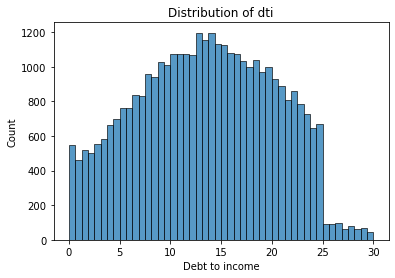

In [63]:
#Description:
   #Excluding mortage according to CL the loan is provided on basis of annual income
#univariate analysis:
sns.histplot(x='dti',data=fdf)
plt.title('Distribution of dti')
plt.xlabel('Debt to income')
plt.show()
#conclusion:
   #Here people in 15 are more.

### Bivariate/Mutlivariate Analysis

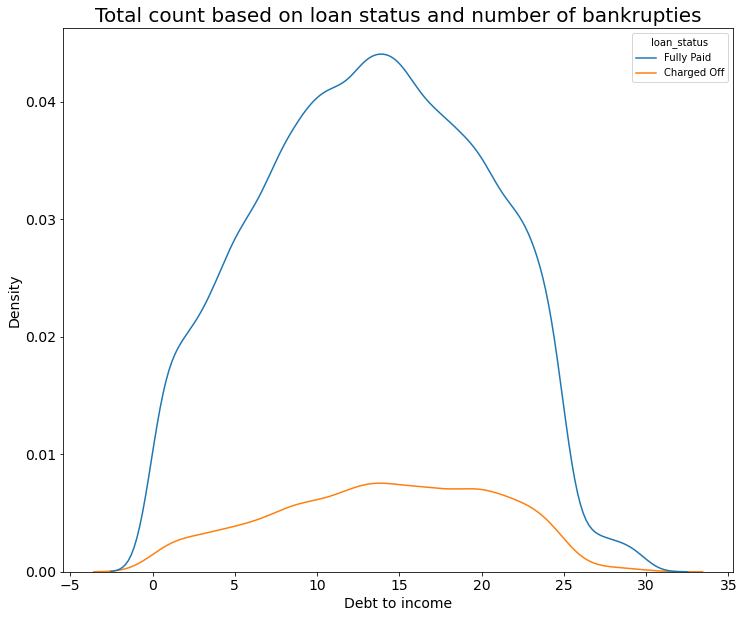

In [64]:
#Bivariate analysis:
figure, ax = plt.subplots(nrows=1,figsize=(12,10))
h=sns.kdeplot(x='dti',hue='loan_status',data=fdf)
h.tick_params(axis='both',labelsize=14)
h.set_xlabel('Debt to income',fontsize=14)
h.set_ylabel('Density',fontsize=14)
h.set_title('Total count based on loan status and number of bankrupties',fontsize=20)
#conclusion:
   #most charged off borrowers are falling in 10 -25 of dti.
plt.show()

### Conclusion drawn about Debt-to-Income ratio

1. Majority of the borrowers have a dti ratio of 13.5
2. Borrowers whose dti ratio is between 10 and 15 is having more chance of defaulting.
3. The chance of defaulting is very less for a borrower if the dti is above 25.

# public records bankruptics

### Univariate Analysis

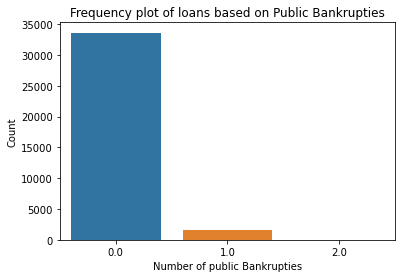

In [65]:
#Description:
  #number of public bankruptics.
#univariate analysis:
sns.countplot(x='pub_rec_bankruptcies',data=fdf)
plt.title('Frequency plot of loans based on Public Bankrupties')
plt.xlabel('Number of public Bankrupties')
plt.ylabel('Count')
plt.show()
#conclusion:
   #Here at 0.0 most of borrowers are falling.

### Bivariate/Mutlivariate Analysis

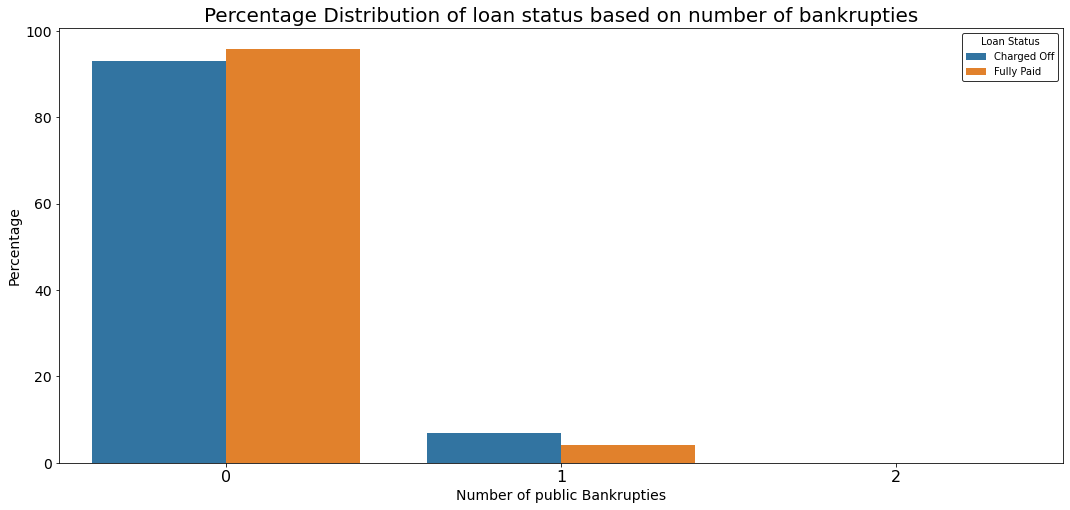

In [66]:
#Bivariate analysis:
figure, ax = plt.subplots(nrows=1,figsize=(18,8))
df1=fdf.groupby('loan_status')['pub_rec_bankruptcies'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
h=sns.barplot(x='pub_rec_bankruptcies',y='percentage',hue='loan_status',data=df1)
h.tick_params(axis='both',labelsize=14)
h.set_xticklabels([0,1,2],fontsize=16)
h.set_xlabel('Number of public Bankrupties',fontsize=14)
h.set_ylabel('Percentage',fontsize=14)
h.legend(title='Loan Status',edgecolor='black',loc=1)
h.set_title('Percentage Distribution of loan status based on number of bankrupties',fontsize=20)
#conclusion:
   #Persons with alteast 1 bankrupties have more chance of defaulting
plt.show()

### Conclusion drawn about Number of bankrupties

1. Most of the borrowers have no recorded bankrupties.
2. The chance of defaulting significantly increases if the borrower is having atleast 1 bankruptcy.

# Issue Date 

### Univariate Analysis

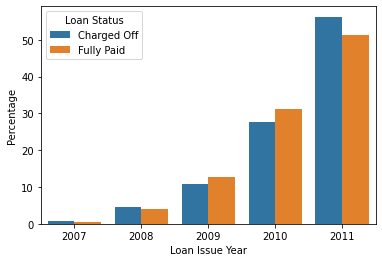

In [67]:
df1=fdf.groupby('loan_status')['loan_issue_year'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
h=sns.barplot(x='loan_issue_year',y='percentage',hue='loan_status',data=df1)
h.legend(title='Loan Status',loc=2)
h.set_xlabel('Loan Issue Year')
h.set_ylabel('Percentage')
plt.show()

### Bivariate/Mutlivariate Analysis 

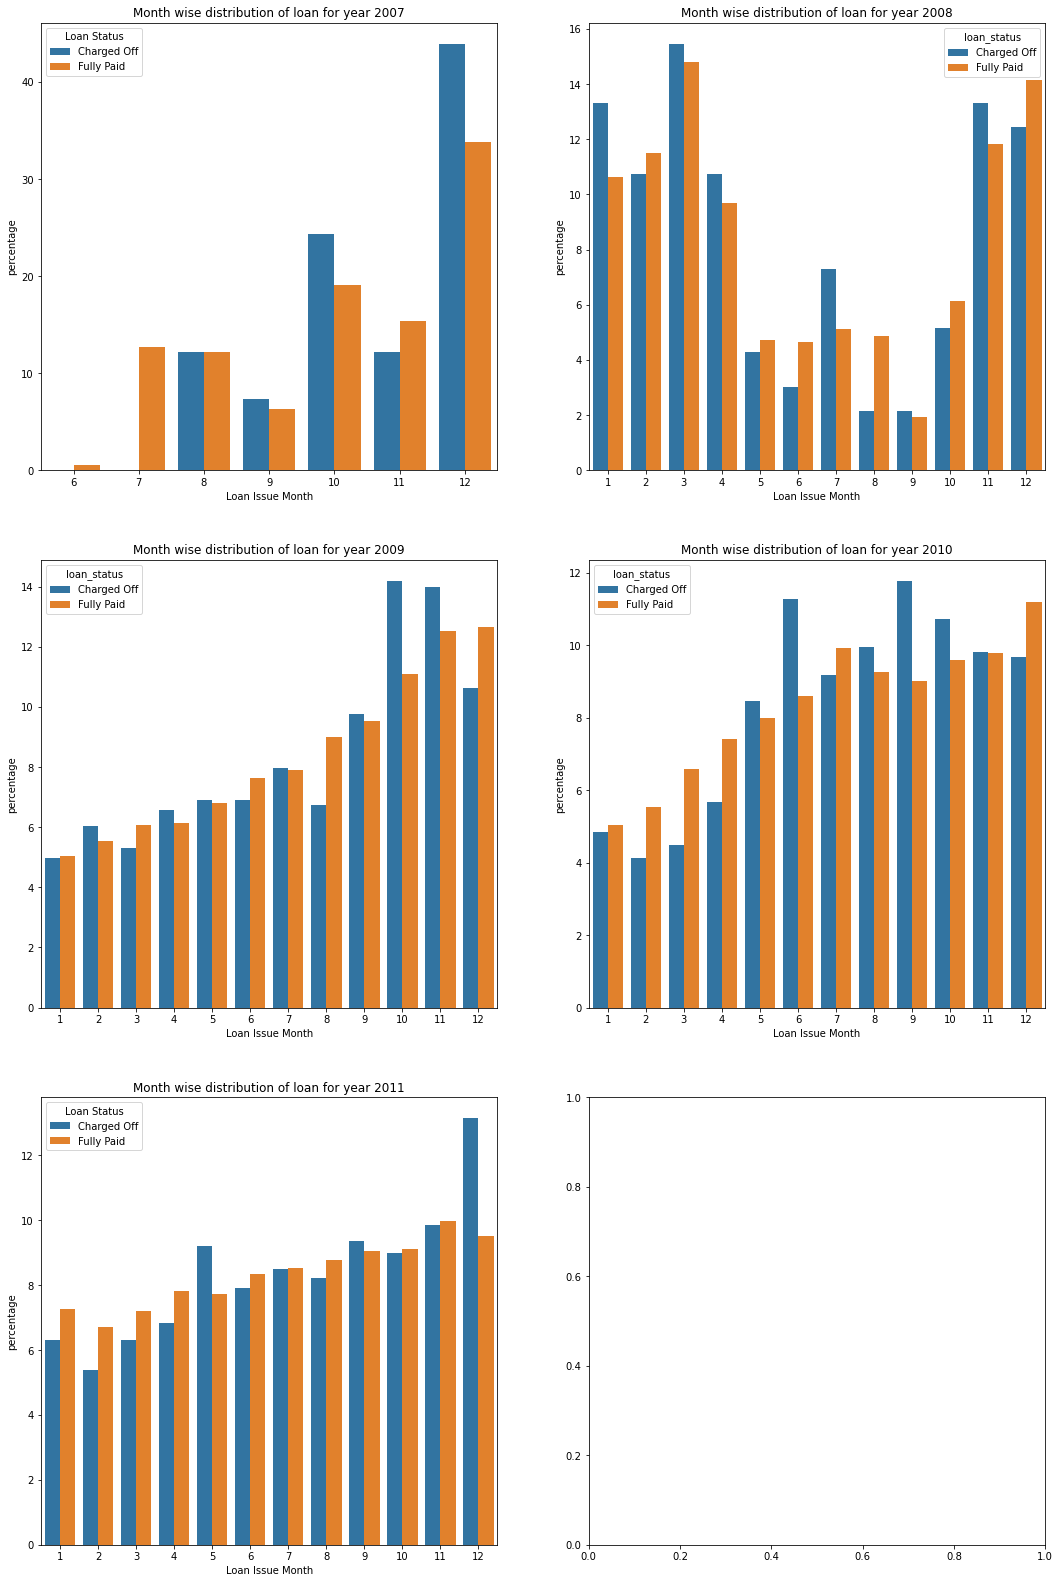

In [68]:
figure, ax = plt.subplots(nrows=3,ncols=2,figsize=(18,28))
df1=fdf[fdf['loan_issue_year']==2007]
df1=df1.groupby('loan_status')['loan_issue_month'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
h=sns.barplot(ax=ax[0, 0],x='loan_issue_month',y='percentage',hue='loan_status',data=df1)
h.set_title('Month wise distribution of loan for year 2007',fontsize=12)
h.set_xlabel('Loan Issue Month')
h.legend(title='Loan Status',loc=2)
df1=fdf[fdf['loan_issue_year']==2008]
df1=df1.groupby('loan_status')['loan_issue_month'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
h=sns.barplot(ax=ax[0, 1],x='loan_issue_month',y='percentage',hue='loan_status',data=df1)
h.set_title('Month wise distribution of loan for year 2008',fontsize=12)
h.set_xlabel('Loan Issue Month')
df1=fdf[fdf['loan_issue_year']==2009]
df1=df1.groupby('loan_status')['loan_issue_month'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
h=sns.barplot(ax=ax[1, 0],x='loan_issue_month',y='percentage',hue='loan_status',data=df1)
h.set_title('Month wise distribution of loan for year 2009',fontsize=12)
h.set_xlabel('Loan Issue Month')
df1=fdf[fdf['loan_issue_year']==2010]
df1=df1.groupby('loan_status')['loan_issue_month'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
h=sns.barplot(ax=ax[1, 1],x='loan_issue_month',y='percentage',hue='loan_status',data=df1)
h.set_title('Month wise distribution of loan for year 2010',fontsize=12)
h.set_xlabel('Loan Issue Month')
df1=fdf[fdf['loan_issue_year']==2011]
df1=df1.groupby('loan_status')['loan_issue_month'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
h=sns.barplot(ax=ax[2, 0],x='loan_issue_month',y='percentage',hue='loan_status',data=df1)
h.set_title('Month wise distribution of loan for year 2011',fontsize=12)
h.set_xlabel('Loan Issue Month')
h.legend(title='Loan Status',loc=2)
plt.show()

### Conclusion drawn about Loan Issue Date

1. We could observe large number of loans taken for the year 2011 compared to previous years. As this data is assumed to be from North America, where there was a recession happened during 2007 till 2009. During that time many people took debt due loss of income and hence during the recovery phase in consecutive years people took loans to pay off the debts and chance of defaulting also increased in subsequent years.
2. Borrowers who took loan in the period of the end of Fiscal year are more chance of defaulting.

# Final Conclusion and Recommendations

Below are the final conclusion which can be drawn after analyzing all the driving variables and can have impact on the borrowers 
abitity to default the loan

1. Borrowers belonging to low income group (Annual income less than `$`40000) have high chance of defaulting.
2. Borrowers belonging to low income group and taking loan between `$`5000 to `$`10000 have high chance of defaulting.
3. Borrowers whose loan to income ratio lies between 0.075 to 0.2 have higher chance of defaulting.
4. Borrowers whose Debt to Income ratio is between 10 and 15 is having more chance of defaulting.
5. Grade C,D,E are the 3 most frequent grades to which a borrower belonging can have high chance of defaulting irrespective of their annual income.
6. Borrowers belonging to grade C and low income group category will have higher chance of defaulting than compared to other grades.
7. For grade C and D the chance of defaulting increases with increase in the sub grade of the borrower (C5 will have higher chance of defaulting than C4).
8. Borrower belonging to low income category and staying in rented property have more chance of defaulting.
9. Borrowers belonging to California(CA) , New York(NY) and Florida (FL) and belonging to Low income category have more chance of defaulting.
10. For lesser loan amounts lesser than`$`10000, people borrowing for education have more chances of defaulting.
11. For loan amounts greater than `$`10000, people borrowing for debt consolidation, credit card, small business have more chances of defaulting.
12. Based on Employment Length one cannot predict if the borrower can default the loan.
13. Based on Verification status one cannot predict if the borrower can default the loan.

## Additional Findings and Improvement Suggestions

### Improvement Areas 

Based on the analysis of the variable we found some of the areas where the lender can try to incorporate the suggestion to attract more customers and increase revenue.

1. The company can increase its profits in states having high number of High Income group borrowers by charging more interest rate. The states are NJ,VA,DC,MD.
2. For borrowers taking loan for renewable energy the company can further reduce interest rates to attract more customers.

### Additional Findings 

Below are some of the additional interesting insights obtained after analyzing the driver variables.

1. We could observe that many borrowers have been given loan at 7.5% interest rate. Beyond the 7.5% value there is sharp decline in the number of borrowers given loan above 7.5%. One of the the reason may be that beyond 7.5% interest rate additional taxes are levived.
2. Borrower belonging to High income category are taking high value loans for renewable energy. This might be due to high subsidy by goverment to push renewable energy utlization.
3. Based on the data we can say that post recovery after the econmomic resession (year 2007-2009), large numbber of loans were taken in order to pay off the debts accumulated during the years of recession.